# **Курсовой проект по курсу "Библиотеки Python для Data Science"**



---



**Тема:** Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).


**Целевая переменная:** Price

**Метрика качества:** R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Требования к решению:**
1. R2 > 0.65
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).


# Загрузка библиотек и установка параметров

In [1286]:
# !pip install catboost

In [1287]:
import numpy as np
import pandas as pd
import random
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
# import copy

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

from catboost import CatBoostRegressor

from IPython.core.display import display, HTML
# display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [1288]:
# Let's turn on to display all pandas's rows for searching and analysis.
# Для удобства отключим ограничения вывода строк pandas.
# pd.options.display.max_rows = None
pd.options.display.max_rows = 60

In [1289]:
COLORS_2 = ['r', 'gold']
COLORS_4 = ['g', 'r', 'grey', 'gold']
SQUARE_MIN = 10.
CURRENT_YEAR = datetime.date.today().year
OUT_CSV = 'EremenkoDV_predictions.csv'

# Загрузка данных

In [1290]:
# def extract_data(file_name, file_path):
#     !kaggle competitions download -c realestatepriceprediction -f $file_name -p $file_path --force

In [1291]:
# Загрузка данных из URL

def load_data():

    # Загрузка обучающих данных
    # Поля 20:
    # Id - идентификационный номер квартиры
    # DistrictId - идентификационный номер района
    # Rooms - количество комнат
    # Square - площадь
    # LifeSquare - жилая площадь
    # KitchenSquare - площадь кухни
    # Floor - этаж
    # HouseFloor - количество этажей в доме
    # HouseYear - год постройки дома
    # Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    # Social_1, Social_2, Social_3 - социальные показатели местности
    # Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    # Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    # Price - цена квартиры
    df_train = pd.read_csv('https://raw.githubusercontent.com/EremenkoDV/ML/master/Part3/Project/train.csv', index_col='Id')
    
    # Загрузка тестовых данных
    # Поля 20:
    # Id - идентификационный номер квартиры
    # DistrictId - идентификационный номер района
    # Rooms - количество комнат
    # Square - площадь
    # LifeSquare - жилая площадь
    # KitchenSquare - площадь кухни
    # Floor - этаж
    # HouseFloor - количество этажей в доме
    # HouseYear - год постройки дома
    # Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    # Social_1, Social_2, Social_3 - социальные показатели местности
    # Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    # Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    df_test = pd.read_csv('https://raw.githubusercontent.com/EremenkoDV/ML/master/Part3/Project/test.csv', index_col='Id')
    
    return df_train, df_test

In [1292]:
# Loading datasets
# Загрузка данных
# Table 0. Origin dataset train.csv.
# Таблица 0. Исходные данные train.csv
df_train, df_test = load_data()
df_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370


# Просмотр, проверка и предварительная оценка датасетов

In [1293]:
# Предварительные оценка и анализ

for df in [df_train, df_test]:
    print('-----------------------------------------------------------')
    # df.shape - информация о размерности датафрейма 
    print(f'Таблица: {df.shape}')
    # df.info() - информация о размерности данных 
    # описание индекса, количество not-a-number элементов 
    df.info()

-----------------------------------------------------------
Таблица: (10000, 19)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1   

In [1294]:
# Согласно таблице 0 и информации о типах столбцов датасетов получим предварительный список категорий.
CATEGORIES = df_train.columns[[9, 10, 11, 12, 13, 15, 16, 17]].tolist()
CATEGORIES

['Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [1295]:
# Table 1. Statistics of train.csv.
# Таблица 1. Исходнная статистика train.csv.
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [1296]:
# Table 2. Statistics of test.csv.
# Таблица 2. Исходнная статистика test.csv.
df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [1297]:
# Table 3. Uniqueness of values in train.csv and test.csv.
# Таблица 3. Уникальность значений train.csv и test.csv.
pd.DataFrame(zip(df_train.columns, df_train.nunique(), np.hstack((df_test.nunique(), \
    np.array(['???']))), np.isin(df_train.columns, CATEGORIES)), \
    columns=['feature_name', 'train_count_values', 'test_count_values', 'category'])

,feature_name,train_count_values,test_count_values,category
0,DistrictId,205,201,False
1,Rooms,9,8,False
2,Square,10000,5000,False
3,LifeSquare,7887,3959,False
4,KitchenSquare,58,38,False
5,Floor,33,35,False
6,HouseFloor,44,41,False
7,HouseYear,97,97,False
8,Ecology_1,129,130,False
9,Ecology_2,2,2,True


In [1298]:
# Let's analyze distribution of category features
# Проанализируем распределение категориальных признаков
# feature_names = df.columns.tolist()
for column in CATEGORIES: 
    print(column)
    print(df[column].value_counts(dropna=False))

Ecology_2
B    4952
A      48
Name: Ecology_2, dtype: int64
Ecology_3
B    4851
A     149
Name: Ecology_3, dtype: int64
Social_1
1     341
2     313
5     268
30    239
25    238
23    220
53    195
22    192
6     166
34    144
31    143
33    139
43    136
46    132
37    114
24    104
52    102
21    101
0     100
35     98
9      94
74     89
47     88
36     88
39     81
11     78
27     76
4      66
28     66
16     65
18     58
19     56
32     55
42     53
17     52
49     49
26     46
66     43
38     42
41     39
29     38
50     33
8      30
14     25
15     21
20     21
7      17
12     14
13     12
10     11
3       9
Name: Social_1, dtype: int64
Social_2
264     297
1564    257
629     228
1437    155
6398    120
       ... 
1423      2
662       2
342       1
528       1
568       1
Name: Social_2, Length: 143, dtype: int64
Social_3
0      1470
1       896
3       540
4       444
2       323
6       214
5       201
141     120
9       116
11       96
7        92
10      

In [1299]:
# Let's check the correlation between features
# Проверим корреляции между признаками
df_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
DistrictId,1.00,0.07,-0.03,-0.02,0.04,-0.12,-0.15,0.01,0.07,0.25,0.17,0.14,0.30,0.31,0.17,0.27
Rooms,0.07,1.00,0.66,0.13,0.01,-0.00,-0.03,-0.01,-0.03,0.08,0.07,0.01,0.04,0.06,0.05,0.55
Square,-0.03,0.66,1.00,0.20,0.01,0.11,0.08,-0.01,-0.06,-0.07,-0.04,0.04,-0.04,-0.02,0.02,0.52
LifeSquare,-0.02,0.13,0.20,1.00,-0.00,0.02,0.03,-0.00,-0.02,-0.05,-0.04,0.01,-0.03,-0.02,-0.01,0.08
KitchenSquare,0.04,0.01,0.01,-0.00,1.00,-0.01,0.00,0.00,-0.01,0.04,0.04,-0.02,0.01,0.04,0.01,0.03
Floor,-0.12,-0.00,0.11,0.02,-0.01,1.00,0.42,0.00,-0.02,-0.04,-0.02,-0.00,-0.14,-0.07,0.02,0.13
HouseFloor,-0.15,-0.03,0.08,0.03,0.00,0.42,1.00,-0.00,-0.00,-0.02,0.01,-0.01,-0.14,-0.07,0.03,0.09
HouseYear,0.01,-0.01,-0.01,-0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,0.00,-0.01,0.01,0.00,0.00
Ecology_1,0.07,-0.03,-0.06,-0.02,-0.01,-0.02,-0.00,0.00,1.00,0.03,0.01,-0.12,-0.04,0.03,-0.08,-0.06
Social_1,0.25,0.08,-0.07,-0.05,0.04,-0.04,-0.02,0.00,0.03,1.00,0.96,0.02,0.08,0.52,0.53,0.26


In [1300]:
# Имеем предварительно сильные признаки в порядке убывания:
df_train_corr = df_train.corr()
high_corr = df_train_corr.loc[(np.abs(df_train_corr['Price']) > 0.2) & \
    (df_train_corr.index != 'Price')].sort_values('Price', \
    ascending=False).index.tolist()
high_corr

['Rooms', 'Square', 'DistrictId', 'Social_1', 'Helthcare_2', 'Social_2']

In [1301]:
# Fill NaN of ['LifeSquare'] = df_train.groupby(['Price_cat', 'Rooms', 'DistrictId'])['LifeSquare'].transform('median')
# Table 4. Distribution of districts by price.
# Таблица 4. Распределение районов по цене.
# df_train.groupby(['DistrictId'])['DistrictId', 'Price'].median('Price').sort_values(['Price']).reset_index(drop=True)
df_train.groupby(['DistrictId'])['Price'].quantile(.5).sort_values().reset_index()

,DistrictId,Price
0,23,113789.561738
1,158,129080.871245
2,209,140048.802277
3,27,146171.433190
4,58,151557.904767
...,...,...
200,182,436180.849402
201,65,452119.101374
202,175,465934.434276
203,195,482791.138606


В реальных данных на цену квартиры (дома) не так сильно влияют ее (его) состояние и класс, как местоположение (широта, долгота, город, район, расстояние до центра города или метро, а также производные от них), которое вносит самый большой вклад в цену. Это предположение подтверждает, например, сравнение графиков динамики цен на 1-комнатные квартиры в г. Москве по районам Арбат (центр) (\~1 000 000 ₽/м2) и Южное Бутово (юг Москвы) (\~200 000 ₽/м2) (https://msk.restate.ru/graph/ceny-prodazhi-1komnatnih/#form1).

В данном датасете наиболее пристально обратим внимание на признак 'DistrictId' (Таблица 4).

Для того, чтобы выполнить качественный прогноз требуется провести большой анализ и сложный feature engineering на основе выбранного признака.


# Предварительная обработка данных. Корректировка ошибок и пропусков

**Анализ и корректировка признака 'HouseYear'. Формирование нового признака 'HouseAge'.**

In [1302]:
# Let's check the feature 'HouseYear' for the correctness in train.csv
# Начнем проверку на корректность с признака 'HouseYear',
# несмотря на то, что корреляция по этому признаку 0.0
# Ошибочных значений в обучающем датасете всего 2.
df_train.loc[(df_train['HouseYear'] > CURRENT_YEAR) | (df_train['HouseYear'] < 0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [1303]:
# Check the feature 'HouseYear' for the correctness in test.csv
# Проверка на корректность с признака 'HouseYear' в test.csv
df_test.loc[(df_test['HouseYear'] > CURRENT_YEAR) | (df_test['HouseYear'] < 0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,


In [1304]:
# УДАЛИТЬ!!!
# df_train.loc[(df_train['Rooms'] == 1.0) & (df_train['Square'] > 35) & (df_train['Square'] < 45) & \
#              (df_train['Price'] > 250000) & (df_train['Price'] < 260000)]
# df_train.loc[(df_train['Price'] > 240000) & (df_train['Price'] < 255000)].sort_values(by=['Rooms', 'Square', 'HouseYear'])
# df_train.loc[(df_train['Price'] > 240000) & (df_train['Price'] < 255000)].groupby('HouseYear').quantile(1).sort_values('Price')
# df_train.loc[(df_train['Price'] > 250000) & (df_train['Price'] < 260000)]['Price'].median()

In [1305]:
# Т.к. некорректных значений немного, то рассмотрим их индивидуально.
# Analysis for the 'HouseYear' = 20052011
# Найдем строки с подобными признаками в обучающем датасете.
# Скорее всего имелось ввиду значение 2005 при похожих других признаках.
# Сравнение по районам из Таблицы 4: 165. DiscrictId=109 ~ 117. DiscrictId=111.
df_train.loc[(df_train['Price'] > 240000) & (df_train['Price'] < 255000) & \
    (df_train['Rooms'] == 1.0) & (df_train['Square'] > 30) & (df_train['Square'] < 70) & \
    (df_train['HouseYear'] == 2005)].sort_values('HouseYear')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
15269,111,1.0,45.477321,21.113644,10.0,11,22.0,2005,0.093443,B,B,23,4635,5,3300.0,2,4,B,250391.987838


In [1306]:
# Analysis for the 'HouseYear' = 4968
# Тоже самое и для 2-го некорректроного значения 'HouseYear'
# Скорее всего имелось ввиду значение 1968 при похожих других признаках.
# Сравнение по районам из Таблицы 4: 120. DiscrictId=147 ~ 127. DiscrictId=103.
df_train.loc[(df_train['Price'] > 240000) & (df_train['Price'] < 255000) & \
    (df_train['Rooms'] == 2.0) & (df_train['Square'] > 30) & (df_train['Square'] < 70) & \
    (df_train['HouseYear'] == 1968)].sort_values('HouseYear')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
424,109,2.0,46.084526,28.946348,6.0,4,10.0,1968,0.136330,B,B,30,6141,10,262.0,3,6,B,247187.598965
11616,103,2.0,46.497817,29.862013,5.0,8,12.0,1968,0.014423,B,B,19,3806,4,NaN,0,3,B,253670.908348
1135,32,2.0,47.313184,32.634504,6.0,9,14.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,253044.071474
7185,50,2.0,39.572627,26.557940,5.0,7,9.0,1968,0.037316,B,B,32,6748,93,562.0,4,10,B,242067.734860
13091,141,2.0,38.364671,25.437341,7.0,4,13.0,1968,0.000000,B,B,23,3684,2,NaN,0,4,B,244668.402337
10875,135,2.0,37.280552,23.829743,7.0,10,9.0,1968,0.007659,B,B,35,7077,56,2301.0,3,19,B,241941.307245


In [1307]:
# Feature changing HouseYear
# Set incorrect values
# Исправляем значения.
df_train.loc[df_train['HouseYear'] == 4968, 'HouseYear'] = 1968
df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [1308]:
# Check for incorrect values
# Проверка
df_train.loc[(df_train['HouseYear'] > CURRENT_YEAR) | (df_train['HouseYear'] < 0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


In [1309]:
# Feature engineering HouseAge
# Let's add (or replace) the new feature of estate's age 'HouseAge'=CURRENT_YEAR-'HouseYear'
# Добавим (заменим в последствии) новый признак возраста недвижимости 'HouseAge'=CURRENT_YEAR-'HouseYear'
df_train['HouseAge'] = CURRENT_YEAR - df_train['HouseYear']
df_test['HouseAge'] = CURRENT_YEAR - df_test['HouseYear']

In [1310]:
df_test.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge
Id,,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,48
15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,43
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,111
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,13
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,3
7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,43
13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,43
5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B,48
4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,B,B,53,14892,4,NaN,1,4,B,23


In [1311]:
# df_train.groupby(['HouseAge'])['HouseAge'].count()
# df_test.groupby(['HouseAge'])['HouseAge'].count()
# df_train[df_train['HouseAge']==43].sort_values('Price').count()
# df_test[df_test['HouseAge']==43].sort_values('Rooms')

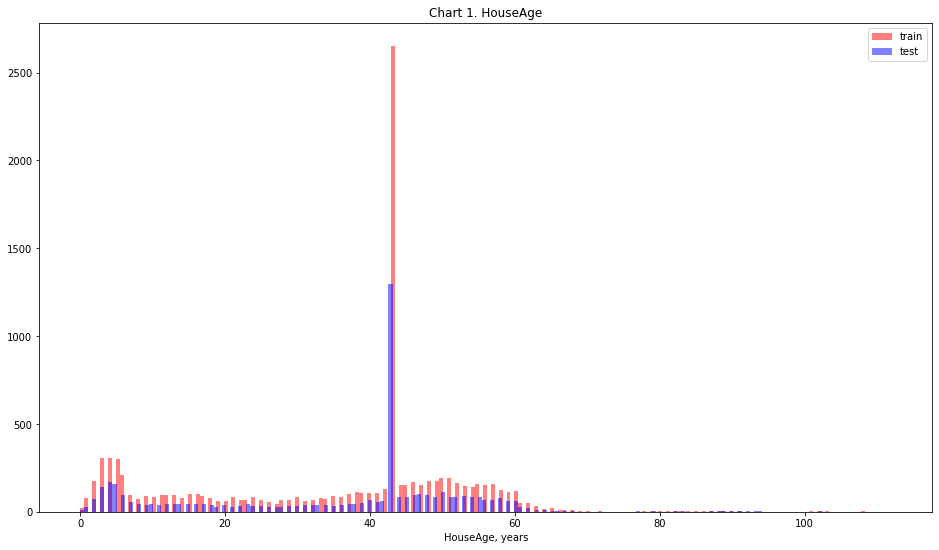

In [1312]:
# Chart 1. Likeness the feature 'HouseAge' between train and test datasets.
# График 1. Схожесть признака 'HouseAge' между обучающей и тестовой датасетами.
# ВНИМАНИЕ!!! Странная особенность: в датасетах очень много 'HouseYear'=1977 (43 года)
# Данная особенность обесценивает данный признак 'HouseYear' ('HouseAge').
plt.figure(figsize = (16, 9))
plt.hist(df_train['HouseAge'], bins=200, density=False, color='r', alpha=.5, label='train')
plt.hist(df_test['HouseAge'], bins=200, density=False, color='b', alpha=.5, label='test')
plt.title('Chart 1. HouseAge')
plt.xlabel('HouseAge, years')
# plt.xlim(40,46)
plt.legend(loc='best');
# plt.xlim(0,200);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


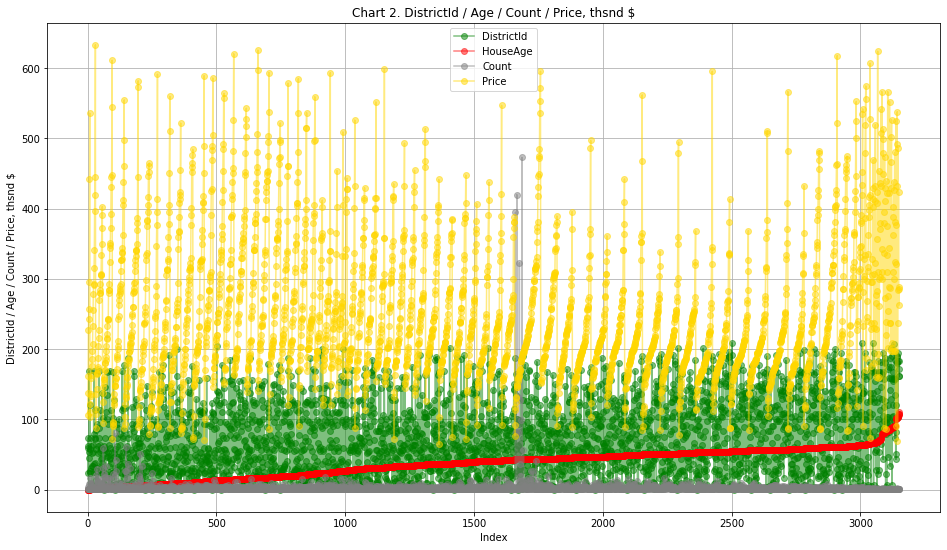

In [1313]:
# Chart 2. Absence of correlation between features 'HouseAge' & 'Price'
# График 2. Отсутствие какой-либо видимой связи признака 'HouseAge' с целевым признаком 'Price'
df_train.groupby(['DistrictId', 'HouseAge'])['DistrictId', 'HouseAge', 'Price'].agg(
    {
        'DistrictId': 'count',
        'HouseAge': 'count',
        'Price': lambda x: np.median(x)/1000
    }).drop('DistrictId', axis=1).rename({'HouseAge': 'Count'}, axis=1).\
    sort_values(['HouseAge', 'Price']).reset_index().\
    plot(color=COLORS_4, figsize=(16, 9), marker='o', grid=True, alpha=.5,\
        title=f'Chart 2. DistrictId / Age / Count / Price, thsnd $',\
        xlabel='Index', ylabel='DistrictId / Age / Count / Price, thsnd $');



---



**Формирование нового признака 'Square_cat'.**

In [1314]:
# Feature engineering Price_cat
# Cut DateFrame by price categories with step $2000
# Для дальнейшего анализа введем ценновой категориальный признак 'Price_cat' с шагом $2000.
# ВНИМАНИЕ!!! К сожалению, этого сильного целевого признака нет в тестовых данных,
# поэтому будем проводить анализ пока только на обучающей выборке train.csv. 
# Для выявления взаимосвязей и создания нового сильного признака этого возможно будет достаточно.
# bins = np.arange(0, 650000, 2000)
# labels = [str(x) + '<$<=' + str(x + 2000) for x in bins[:-1]]
# df_train['Price_cat'] = pd.cut(df_train['Price'], bins=bins, labels=labels)

In [1315]:
# Feature engineering Square_cat
# Cut DateFrame by square categories with step 2m^2
# Аналогично для дальнейшего анализа введем категориальный признак 'Square_cat' с шагом 2m^2.
bins = np.arange(0, 650, 2)
labels = [str(x) + '<m^2<=' + str(x + 2) for x in bins[:-1]]
df_train['Square_cat'] = pd.cut(df_train['Square'], bins=bins, labels=labels)
df_test['Square_cat'] = pd.cut(df_test['Square'], bins=bins, labels=labels)



---



**Анализ схожести обучающего и тестового датасета по основным признакам.**

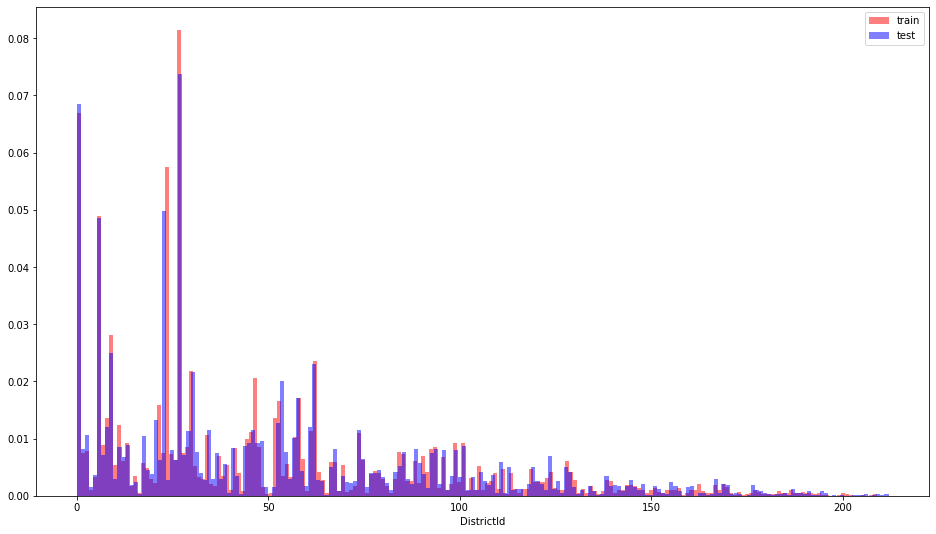

In [1316]:
# Chart 1. Likeness of the feature 'DistrictId' between train and test datasets.
# График 1. Схожесть признака 'DistrictId' между обучающей и тестовой датасетами.
# Можно предположить, что наибольшее расхождение формируемого признака на основе 'DistrictId'
# будет в тех районах, в которых отсутствуют или сильно расходятся данные в train.csv от test.csv
plt.figure(figsize = (16, 9))
plt.hist(df_train['DistrictId'], bins=200, density=True, color='r', alpha=.5, label='train')
plt.hist(df_test['DistrictId'], bins=200, density=True, color='b', alpha=.5, label='test')
plt.xlabel('DistrictId')
plt.legend(loc='best');
# plt.xlim(0,200);

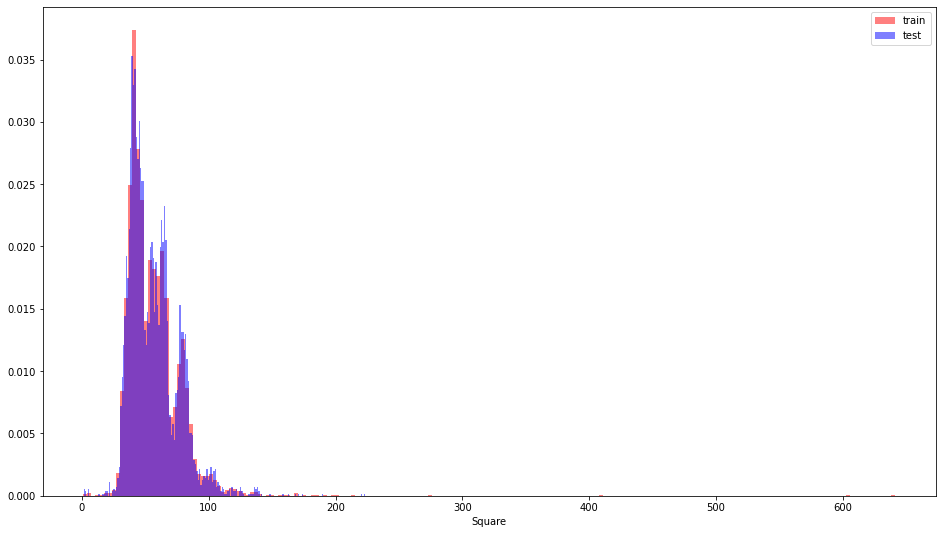

In [1317]:
# Chart 2. Likeness the feature 'Square' between train and test datasets.
# График 2. Схожесть признака 'Square' между обучающей и тестовой датасетами.
plt.figure(figsize = (16, 9))
plt.hist(df_train['Square'], bins=200, density=True, color='r', alpha=.5, label='train')
plt.hist(df_test['Square'], bins=200, density=True, color='b', alpha=.5, label='test')
plt.xlabel('Square')
plt.legend(loc='best');
# plt.xlim(0,200);

Из большой схожести признаков следует, что тестовый датасет есть часть от одного общего датасета, и новые признаки, основанные на обучающем датасете должны хорошо применяться к тестовому.



---



**Анализ и корректировка признаков 'Rooms', 'Square' и 'LifeSquare'.**

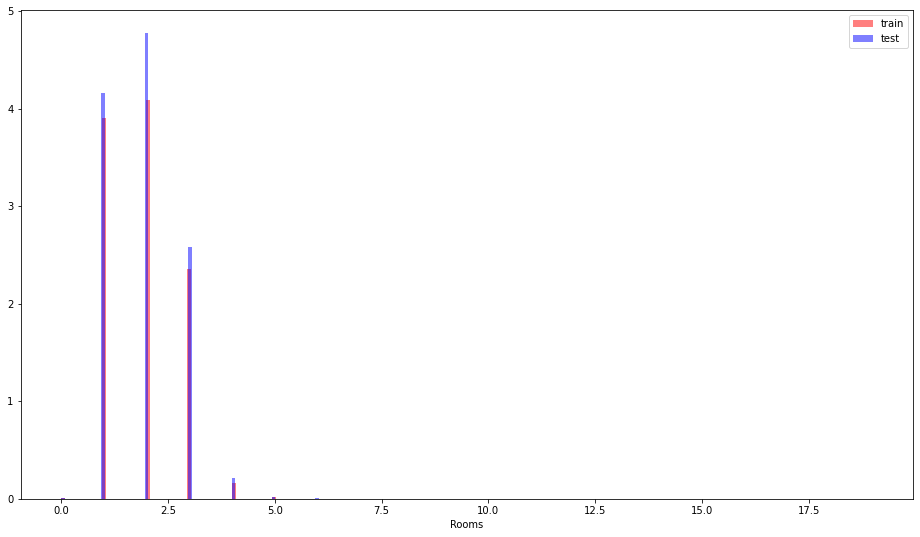

In [1318]:
# Chart 3. Likeness the feature 'Square' between train and test datasets.
# График 3. Схожесть признака 'Square' между обучающей и тестовой датасетами.
# ВНИМАНИЕ!!! Следует обратить на наличие на Rooms лежащих вне диапазона [1, 6].
plt.figure(figsize = (16, 9))
plt.hist(df_train['Rooms'], bins=200, density=True, color='r', alpha=.5, label='train')
plt.hist(df_test['Rooms'], bins=200, density=True, color='b', alpha=.5, label='test')
plt.xlabel('Rooms')
plt.legend(loc='best');
# plt.xlim(0,10);

In [1319]:
# Table 5. Uncorrected or doubtful values of the feature 'Rooms'.
# Таблица 5. Некорректные или сомнительные значения признака 'Rooms'.
df_train.loc[(df_train['Rooms'] < 1) | (df_train['Rooms'] > 5)].sort_values('Rooms')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,
12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389,4,138<m^2<=140
7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887,12,212<m^2<=214
7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788,43,40<m^2<=42
770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463,5,48<m^2<=50
456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112,43,80<m^2<=82
3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,43,2<m^2<=4
3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646,38,38<m^2<=40
9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007,43,86<m^2<=88
14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416,51,58<m^2<=60


In [1320]:
# Distribution of price by square & numbers of rooms.
# Распределение цены от площади и количества комнат.
df_train_square = df_train.groupby(['Square_cat', 'Rooms'])['Square_cat', 'Rooms', 'Price'].agg(
    {
        'Square_cat': 'count',
        'Rooms': 'count',
        'Price': lambda x: np.median(x)/1000
    })
df_train_square.drop(columns=['Rooms'], axis=1, inplace=True)
df_train_square.loc[(pd.isna(df_train_square['Price'])), 'Price'] = 0.0
df_train_square.rename(columns={'Square_cat': 'Count'}, inplace=True)
df_train_square.index = df_train_square.index.get_level_values(0).astype('str', copy=False).str.split('<').str[0] + ":" + \
    df_train_square.index.get_level_values(1).astype('int', copy=False).astype('str', copy=False)
df_train_square

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Count,Price
0:0,0,0.000000
0:1,2,319.906801
0:2,0,0.000000
0:3,0,0.000000
0:4,0,0.000000
...,...,...
646:4,0,0.000000
646:5,0,0.000000
646:6,0,0.000000
646:10,0,0.000000


In [1321]:
# Оценка наличия хотя бы одного признака, имеющего NaN более 90%
# (df_train_square.isna().sum() / len(df_train_square) > 0.9).sum()

In [1322]:
# Table 5. For exsample. Uncorrected values of the feature 'Rooms'=2.
# Таблица 5. Для примера. Некорректные значения признака 'Rooms'=2.
df_train.loc[(df_train['Rooms'] == 2) & (df_train['Square'] > 150)].sort_values('Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,
5376,93,2.0,170.379494,NaN,1.0,3,2.0,1977,0.004949,B,B,0,186,0,NaN,0,0,B,194582.912756,43,170<m^2<=172
28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538,43,604<m^2<=606
11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562,1,640<m^2<=642


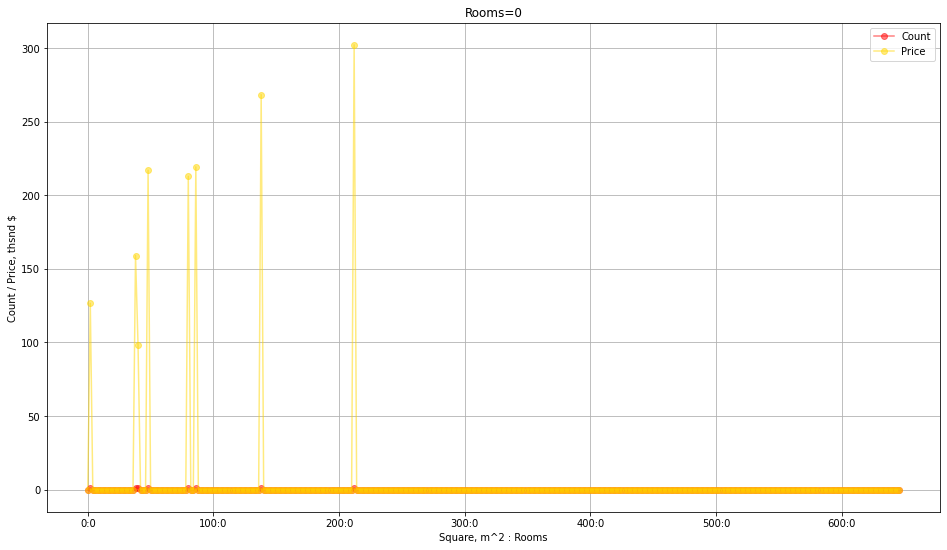

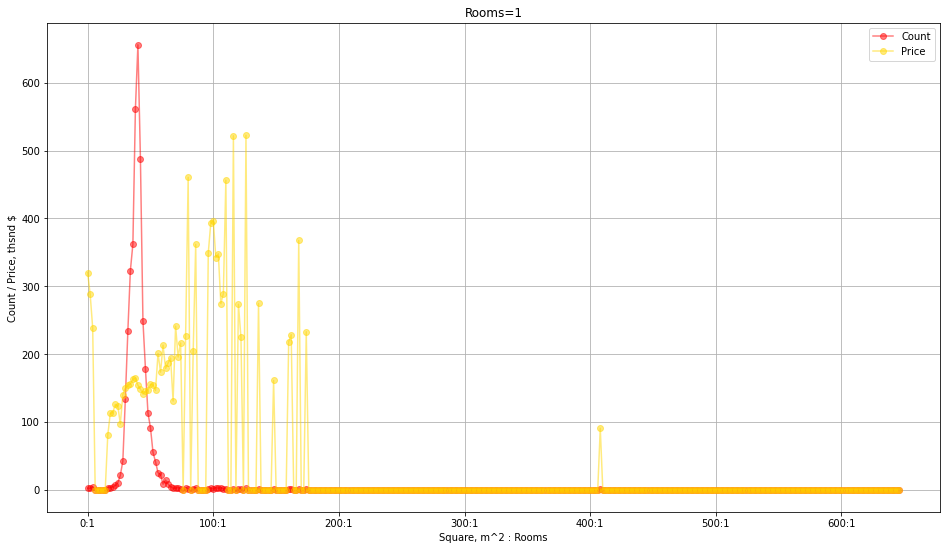

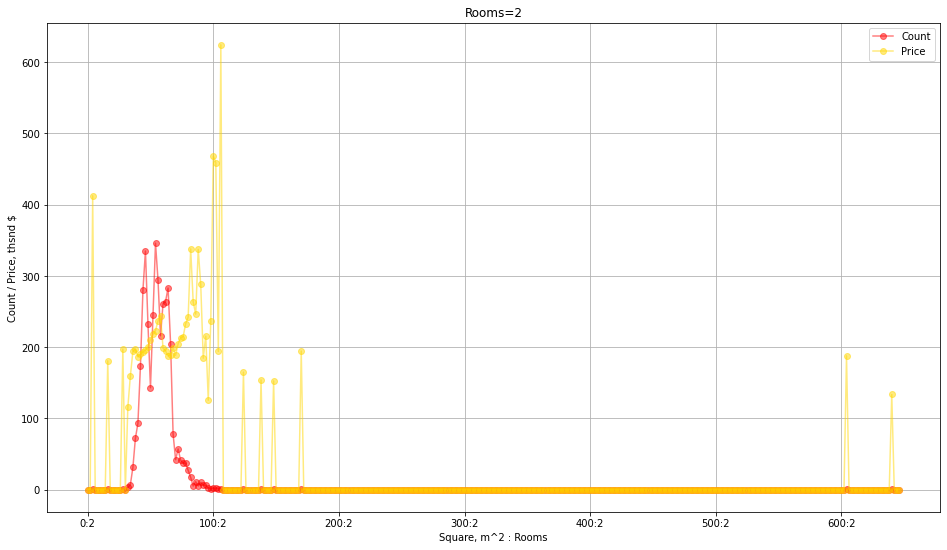

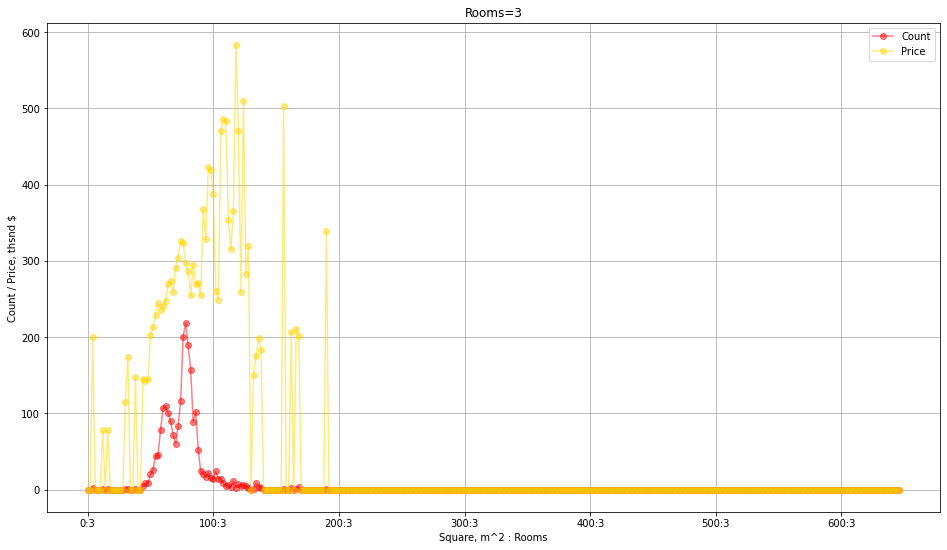

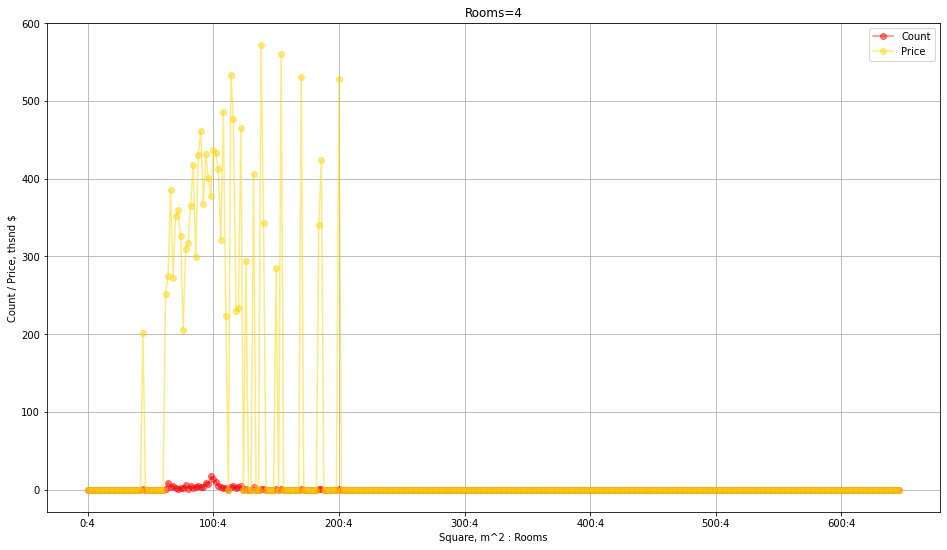

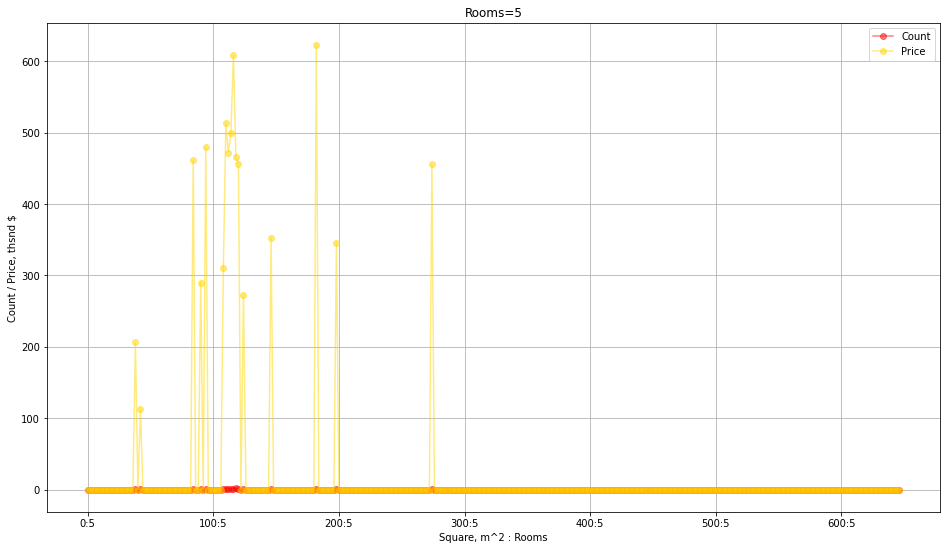

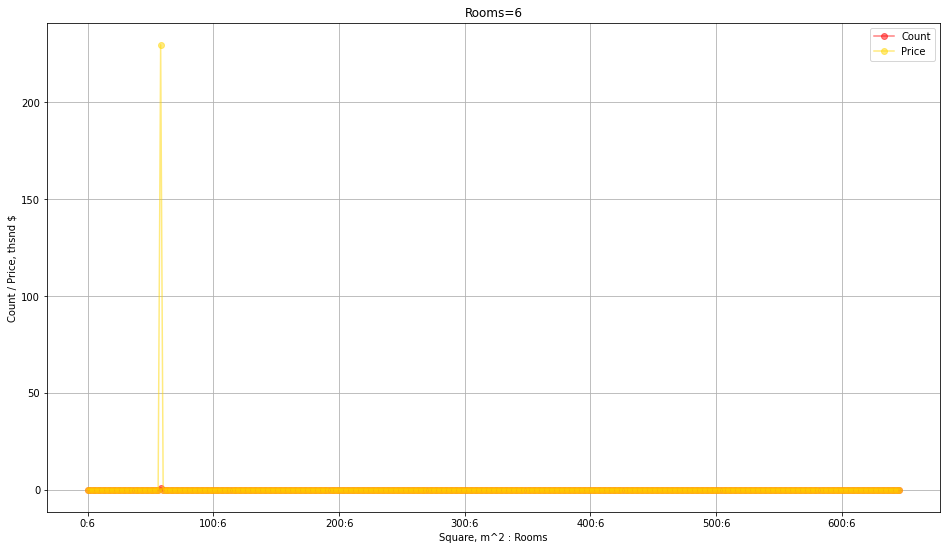

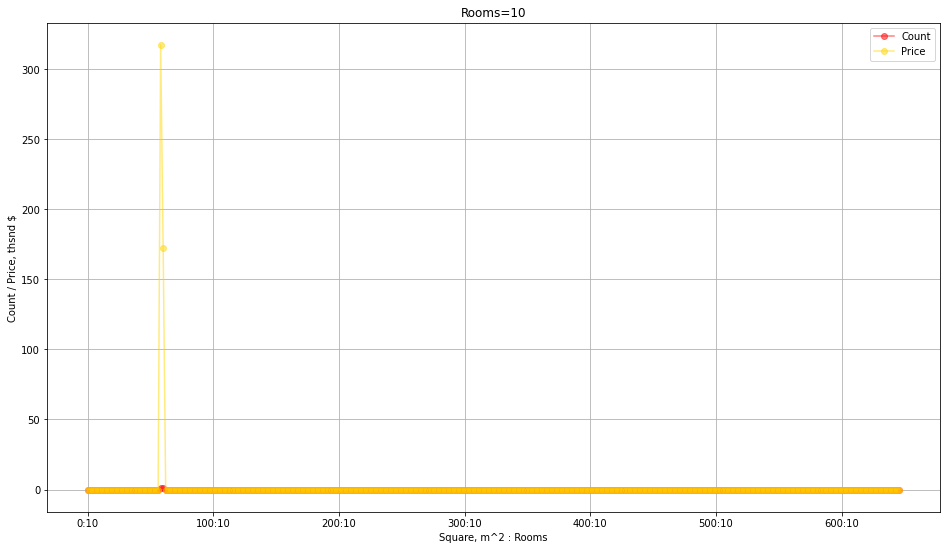

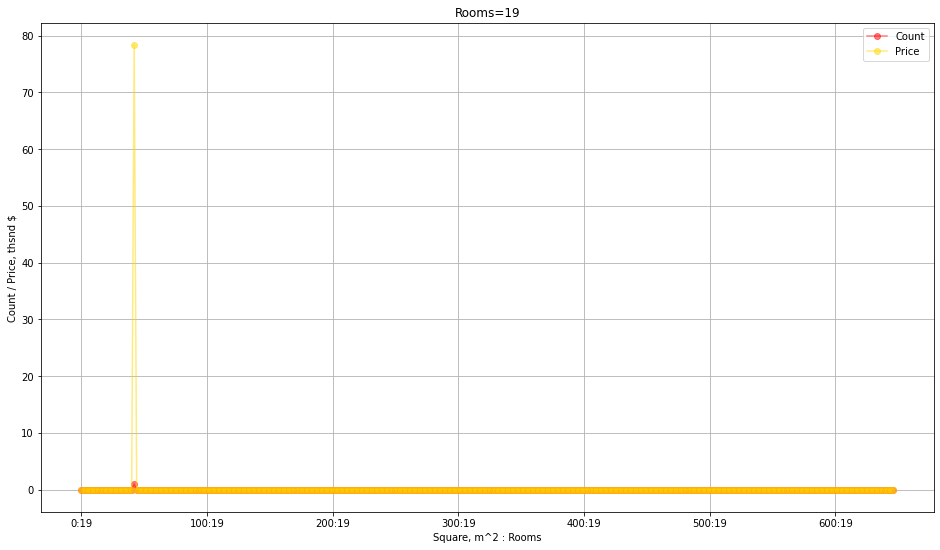

In [1323]:
# Charts 4. Distribution of Count & Price by Square & Rooms.
# Графики 4. Распределение количества и цены от площади и количества комнат.
# 'Rooms' - один из главных признаков, влияющих на цену, но не наоборот.
# Количество комнат зависит прежде всего от площади всей квартиры,
# поэтому попробуем откорректировать невозможные значения на обоих датасетах.
# Из таблиц 4, 5 и графиков 4 (далее) видно, что квартиры со значениями количества комнат:
# 0, 6, 10, 19, а также некоторых в диапазоне [1,5] не соответствуют площади.
for i in sorted(np.unique(df_train_square.index.map(lambda x: x.split(':')[-1])), key=int):
    df_train_square.loc[(df_train_square.index.map(lambda x: x.split(':')[-1]) == i)].\
        plot(color=COLORS_2, figsize=(16, 9), marker='o', grid=True, alpha=.5, title=f'Rooms={i}',\
            xlabel='Square, m^2 : Rooms', ylabel='Count / Price, thsnd $');


In [1324]:
# Feature changing Rooms
# По схожести графиков 2 и 3 можно сделать вывод о том, что корректировка признака 'Rooms',
# сделанная для train.csv подходит и для test.csv.
# Установим по графикам индивидуальные диапазоны площадей для каждого количества комнат.
# Обнулим для дальнейшей корректировки признак 'Rooms', для значений вне диапазонов.
square_range_per_rooms = {
    '1': [0, 150],
    '2': [20, 200],
    '3': [40, 250],
    '4': [60, 400],
    '5': [80, 600],
    '6': [100, 700],
    '10': [100, 800],
    '17': [100, 1200],
    '19': [100, 1500]
    }
for i in square_range_per_rooms:
    print(f"\nУстановим площадь для 'Rooms'={i} в диапазоне [{square_range_per_rooms[i][0]},{square_range_per_rooms[i][-1]}].")

    df_train.loc[(df_train['Rooms'] == float(i)) &
        ((df_train['Square'] < square_range_per_rooms[i][0]) | (df_train['Square'] > square_range_per_rooms[i][-1])), 'Rooms'] = 0.0
    print(f"Датасет: train.csv. Выбросы вне диапазона:" +
        str(df_train.loc[(df_train['Rooms'] == float(i)) &
        ((df_train['Square'] < square_range_per_rooms[i][0]) |
        (df_train['Square'] > square_range_per_rooms[i][-1]))].size))

    df_test.loc[(df_test['Rooms'] == float(i)) &
        ((df_test['Square'] < square_range_per_rooms[i][0]) | (df_test['Square'] > square_range_per_rooms[i][-1])), 'Rooms'] = 0.0
    print(f"Датасет: test.csv. Выбросы вне диапазона:" +
        str(df_test.loc[(df_test['Rooms'] == float(i)) &
        ((df_test['Square'] < square_range_per_rooms[i][0]) |
        (df_test['Square'] > square_range_per_rooms[i][-1]))].size))


Установим площадь для 'Rooms'=1 в диапазоне [0,150].
Датасет: train.csv. Выбросы вне диапазона:0
Датасет: test.csv. Выбросы вне диапазона:0

Установим площадь для 'Rooms'=2 в диапазоне [20,200].
Датасет: train.csv. Выбросы вне диапазона:0
Датасет: test.csv. Выбросы вне диапазона:0

Установим площадь для 'Rooms'=3 в диапазоне [40,250].
Датасет: train.csv. Выбросы вне диапазона:0
Датасет: test.csv. Выбросы вне диапазона:0

Установим площадь для 'Rooms'=4 в диапазоне [60,400].
Датасет: train.csv. Выбросы вне диапазона:0
Датасет: test.csv. Выбросы вне диапазона:0

Установим площадь для 'Rooms'=5 в диапазоне [80,600].
Датасет: train.csv. Выбросы вне диапазона:0
Датасет: test.csv. Выбросы вне диапазона:0

Установим площадь для 'Rooms'=6 в диапазоне [100,700].
Датасет: train.csv. Выбросы вне диапазона:0
Датасет: test.csv. Выбросы вне диапазона:0

Установим площадь для 'Rooms'=10 в диапазоне [100,800].
Датасет: train.csv. Выбросы вне диапазона:0
Датасет: test.csv. Выбросы вне диапазона:0

Уст

In [1325]:
# Let's reform DataFrame df_train_square.
# Переформируем датафрейм df_train_square.
# Distribution of price by square & numbers of rooms.
# Распределение цены от площади и количества комнат.
df_train_square = df_train.groupby(['Square_cat', 'Rooms'])['Square_cat', 'Rooms', 'Price'].agg(
    {
        'Square_cat': 'count',
        'Rooms': 'count',
        'Price': lambda x: np.median(x)/1000
    })
df_train_square.drop(columns=['Rooms'], axis=1, inplace=True)
df_train_square.loc[(pd.isna(df_train_square['Price'])), 'Price'] = 0.0
df_train_square.rename(columns={'Square_cat': 'Count'}, inplace=True)
df_train_square.index = df_train_square.index.get_level_values(0).astype('str', copy=False).str.split('<').str[0] + ":" + \
    df_train_square.index.get_level_values(1).astype('int', copy=False).astype('str', copy=False)
df_train_square

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,Count,Price
0:0,0,0.000000
0:1,2,319.906801
0:2,0,0.000000
0:3,0,0.000000
0:4,0,0.000000
...,...,...
646:1,0,0.000000
646:2,0,0.000000
646:3,0,0.000000
646:4,0,0.000000


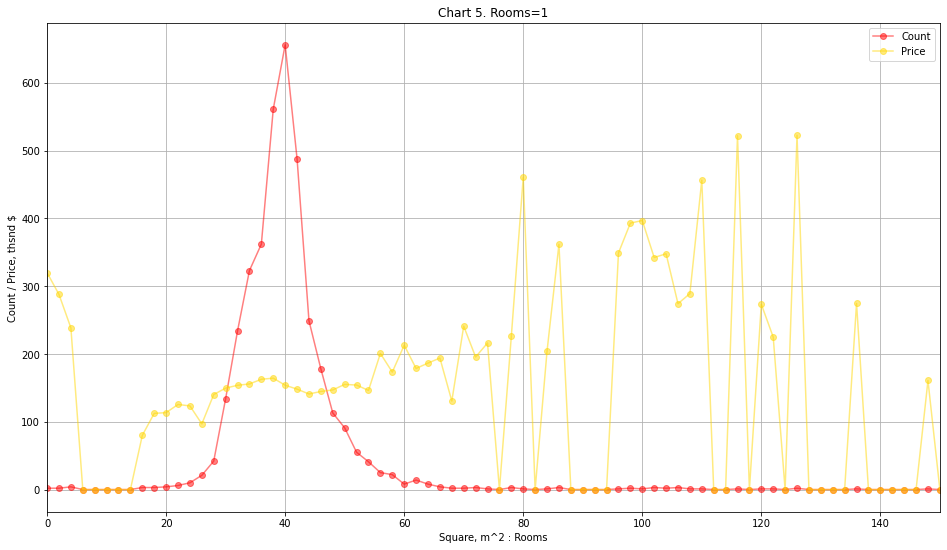

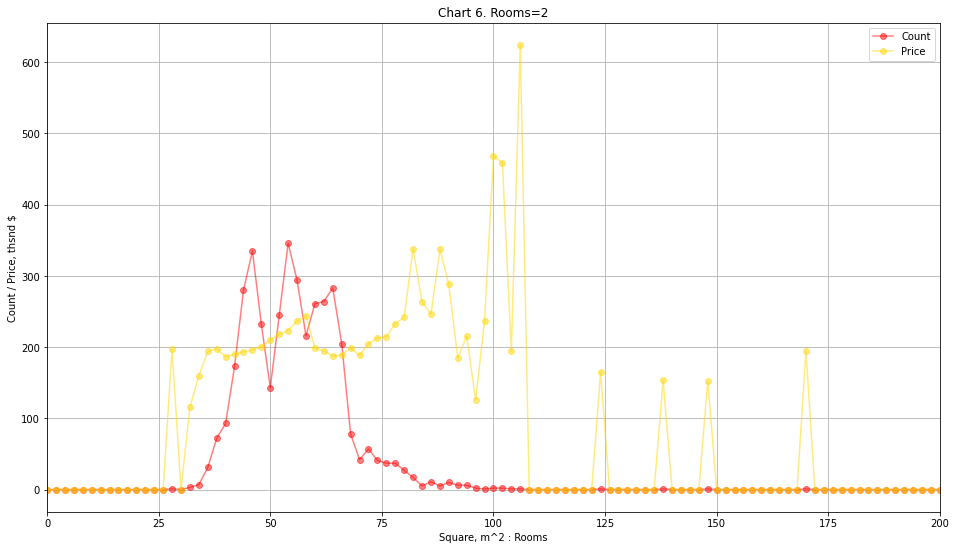

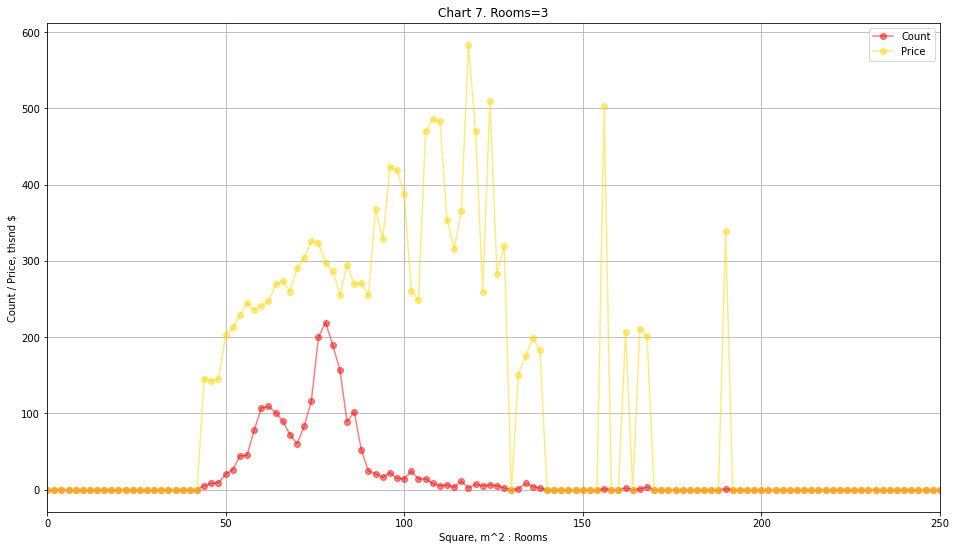

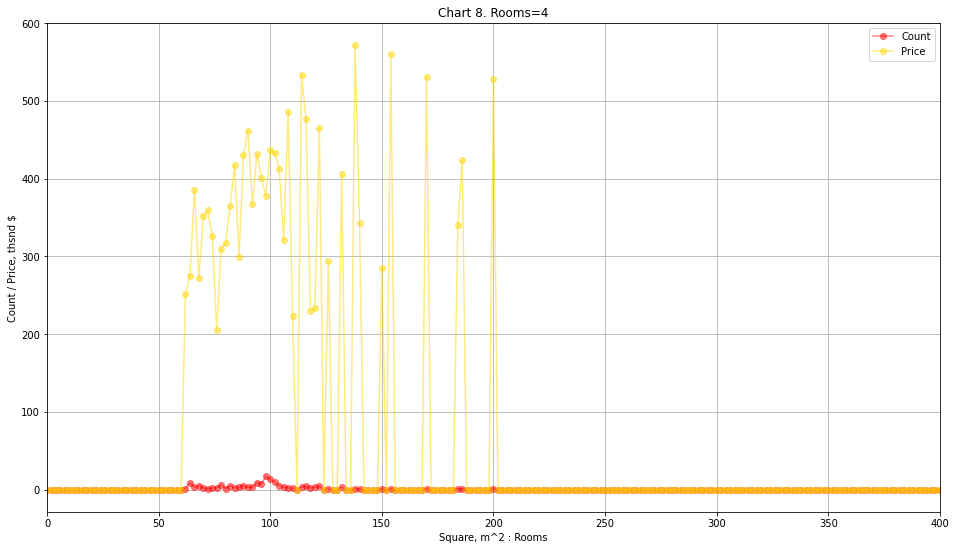

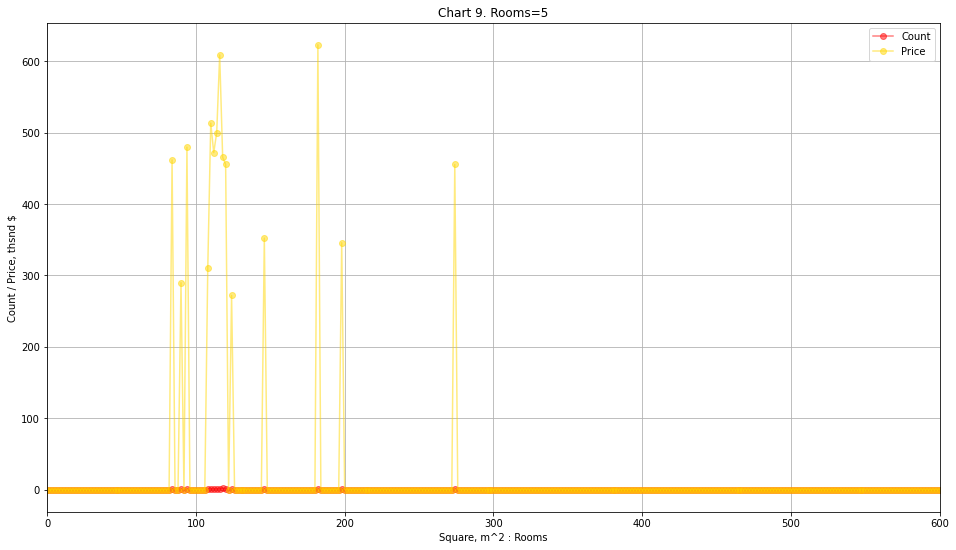

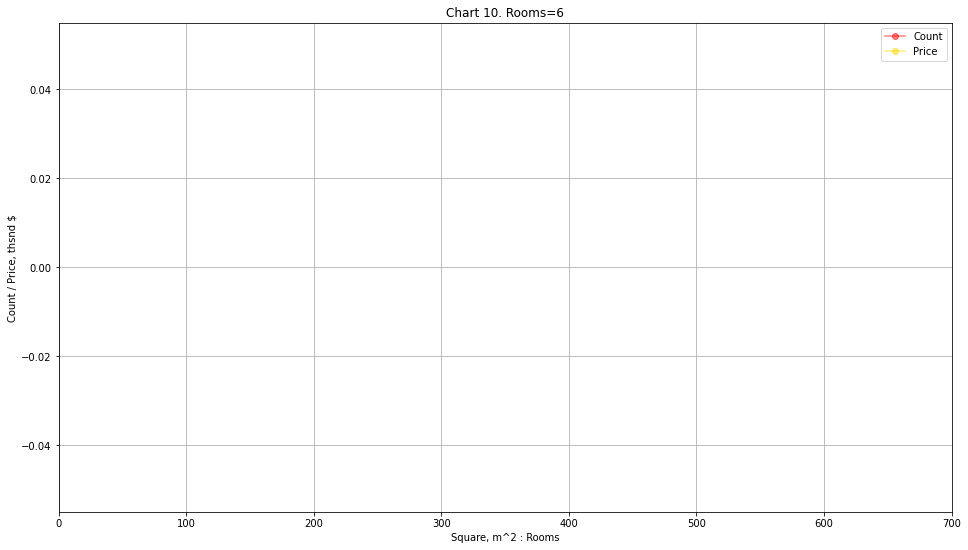

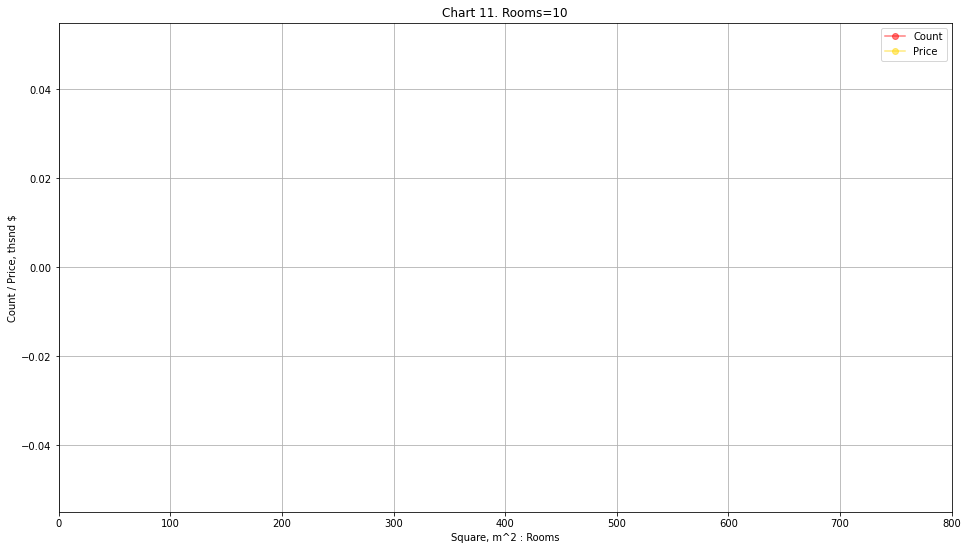

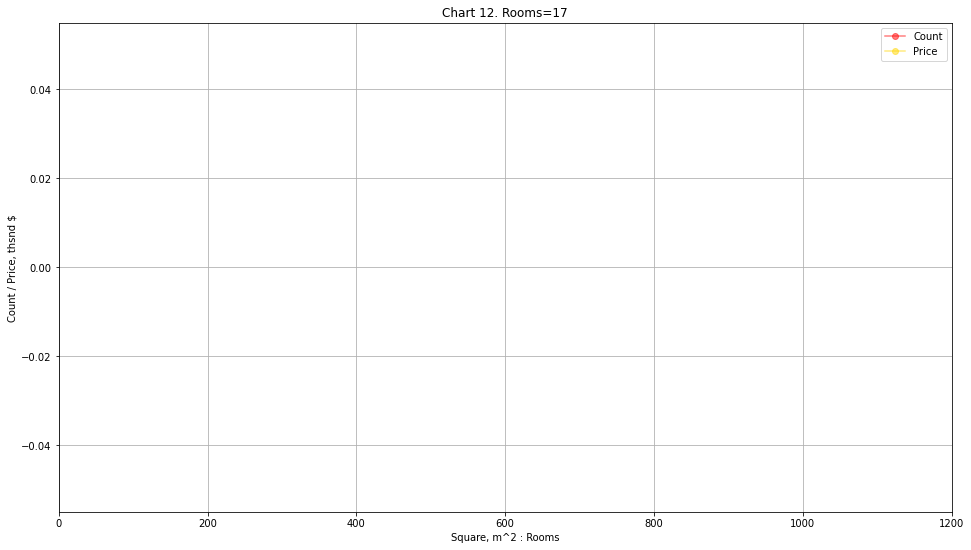

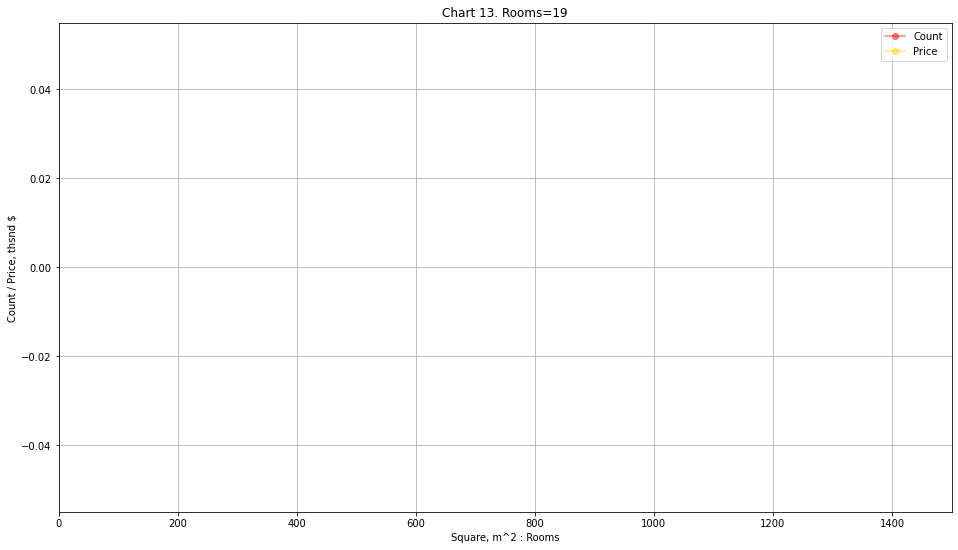

In [1326]:
# Let's reform charts after corrections.
# Переформируем графики распределения после исправлений.
chart_number = 4
for i in square_range_per_rooms:
    chart_number += 1

    df_train_square_temp = df_train_square.loc[(df_train_square.index.map(lambda x: x.split(':')[-1]) == i)]
    df_train_square_temp.index = df_train_square_temp.index.map(lambda x: x.split(':')[0]).astype('int', copy=False)
    df_train_square_temp.plot(color=COLORS_2, figsize=(16, 9), marker='o', \
                        grid=True, alpha=.5, title=f'Chart {chart_number}. Rooms={i}', \
                        xlim=(0,square_range_per_rooms[i][-1]), \
                        xlabel='Square, m^2 : Rooms', ylabel='Count / Price, thsnd $');

In [1327]:
# Feature changing Square
# ??? НУЖНО ЛИ МЕНЯТЬ ???
# Dataset:train.csv. Let's set incorrect values of feature 'Square' if 'LifeSquare' - 'Square' < 100.
# Dataset:train.csv. Установим некорректные значения 'Square', если 'LifeSquare' - 'Square' < 100.
df_train.loc[(df_train['LifeSquare'] > SQUARE_MIN) & (df_train['LifeSquare'] - df_train['Square'] > 0) & \
             (df_train['LifeSquare'] - df_train['Square'] < 100), 'Square'] = df_train['LifeSquare']
df_train.loc[(df_train['LifeSquare'] > SQUARE_MIN) & (df_train['LifeSquare'] - df_train['Square'] > 0) & \
             (df_train['LifeSquare'] - df_train['Square'] < 100)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,


In [1328]:
# Feature changing Square
# ??? НУЖНО ЛИ МЕНЯТЬ ???
# Dataset:test.csv. Let's set incorrect values of feature 'Square' if 'LifeSquare' - 'Square' < 100.
# Dataset:test.csv. Установим некорректные значения 'Square', если 'LifeSquare' - 'Square' < 100.
df_test.loc[(df_test['LifeSquare'] > SQUARE_MIN) & (df_test['LifeSquare'] - df_test['Square'] > 0) & \
            (df_test['LifeSquare'] - df_test['Square'] < 100), 'Square'] = df_test['LifeSquare']
df_test.loc[(df_test['LifeSquare'] > SQUARE_MIN) & (df_test['LifeSquare'] - df_test['Square'] > 0) & \
            (df_test['LifeSquare'] - df_test['Square'] < 100)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,


In [1329]:
# Feature changing LifeSquare
# ??? НУЖНО ЛИ МЕНЯТЬ ???
# Dataset:train.csv. Let's set incorrect values of feature 'LifeSquare' if 'LifeSquare' > 'Square'.
# Dataset:train.csv. Установим некорректные значения 'LifeSquare', если 'LifeSquare' > 'Square'.
df_train.loc[df_train['LifeSquare'] > df_train['Square'], 'LifeSquare'] = df_train['Square']
df_train.loc[df_train['LifeSquare'] > df_train['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,


In [1330]:
# Feature changing LifeSquare
# ??? НУЖНО ЛИ МЕНЯТЬ ???
# Dataset:test.csv. Let's set incorrect values of feature 'LifeSquare' if 'LifeSquare' > 'Square'.
# Dataset:test.csv. Установим некорректные значения 'LifeSquare', если 'LifeSquare' > 'Square'.
df_test.loc[df_test['LifeSquare'] > df_test['Square'], 'LifeSquare'] = df_test['Square']
df_test.loc[df_test['LifeSquare'] > df_test['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,


In [1331]:
# Формирование датасета с количеством и медианными значениями площади в разрезе Rooms
# df_train_square = df_train.groupby(['Rooms'])[['Rooms', 'Square']].agg({'Rooms': 'count', 'Square': 'median'})
# df_train_square = df_train.groupby(['Rooms'])['Square'].median('Square')
df_train_square = df_train.groupby(['Rooms'])['Square'].median('Square').reset_index()
df_train_square

,Rooms,Square
0,0.0,59.056975
1,1.0,40.492737
2,2.0,55.894555
3,3.0,77.495879
4,4.0,98.691303
5,5.0,118.363960


In [1332]:
# Пример преобразования
# x = (df[df['action']=='SELL'].reset_index()
#        .merge(df.loc[df['action']=='BUY', ['timeframe','action','price']],
#               on='timeframe', suffixes=['_sell','_buy'])
#        .eval("result = (price_sell / price_buy - 1) * 100")
#        .set_index('index'))

In [1333]:
# Dataset:train.csv. Формирование датасета-справочника с медианными значениями 'Square'
# в разрезе 'Rooms' для некорректных данных с 'Square' < SQUARE_MIN
x = df_train.loc[df_train['Square'] < SQUARE_MIN, ['Rooms', 'Square']].reset_index().\
    merge(df_train.groupby(['Rooms'])['Square'].median('Square').reset_index(),
    on='Rooms', suffixes=['_train','_median']).set_index('Id')
x

,Rooms,Square_train,Square_median
Id,,,
11526,1.0,4.633498,40.492737
10202,1.0,2.596351,40.492737
9487,1.0,5.129222,40.492737
14786,1.0,1.136859,40.492737
15744,1.0,1.988943,40.492737
6782,1.0,2.954309,40.492737
7657,1.0,4.502784,40.492737
3224,0.0,2.377248,59.056975
4504,0.0,4.390331,59.056975


In [1334]:
# Feature changing Square
# Dataset:train.csv. Let's set incorrect values of feature 'Square' if 'Square' < SQUARE_MIN.
# Dataset:train.csv. Установим некорректные значения 'Square', если 'Square' < SQUARE_MIN.
df_train.loc[df_train['Square'] < SQUARE_MIN, 'Square'] = x['Square_median']
# df_train[df_train['Square'] < SQUARE_MIN].sort_values('Price')
idxs = [11526,10202,9487,14786,15744,6782,7657,3224,4504]
df_train.query("index in @idxs")

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,
11526,27,1.0,40.492737,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,43,4<m^2<=6
10202,6,1.0,40.492737,2.596351,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,6,2<m^2<=4
9487,5,1.0,40.492737,5.129222,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,43,4<m^2<=6
3224,27,0.0,59.056975,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,43,2<m^2<=4
4504,27,0.0,59.056975,4.390331,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,4,4<m^2<=6
14786,1,1.0,40.492737,1.136859,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,43,0<m^2<=2
15744,34,1.0,40.492737,1.988943,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,43,0<m^2<=2
6782,45,1.0,40.492737,2.954309,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,43,2<m^2<=4
7657,38,1.0,40.492737,4.502784,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,43,4<m^2<=6


In [1335]:
# Dataset:test.csv. Формирование датасета-справочника с медианными значениями 'Square'
# в разрезе 'Rooms' для некорректных данных с 'Square' < SQUARE_MIN
x = df_test.loc[df_test['Square'] < SQUARE_MIN, ['Rooms', 'Square']].reset_index().\
    merge(df_test.groupby(['Rooms'])['Square'].median('Square').reset_index(),
    on='Rooms', suffixes=['_train','_median']).set_index('Id')
x

,Rooms,Square_train,Square_median
Id,,,
9011,1.0,1.378543,40.282542
16401,1.0,2.645046,40.282542
2138,1.0,5.647458,40.282542
10120,1.0,5.100672,40.282542
1165,1.0,2.372101,40.282542
7855,1.0,4.967143,40.282542
1420,1.0,1.975769,40.282542


In [1336]:
# Feature changing Square
# Dataset:test.csv. Let's set incorrect values of feature 'Square' if 'Square' < SQUARE_MIN.
# Dataset:test.csv. Установим некорректные значения 'Square', если 'Square' < SQUARE_MIN.
df_test.loc[df_test['Square'] < SQUARE_MIN, 'Square'] = x['Square_median']
# df_test[df_test['Square'] < SQUARE_MIN]
idxs = [9011,16401,2138,10120,15435,7855,1420]
df_test.query("index in @idxs")

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,
9011,53,1.0,40.282542,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,43,0<m^2<=2
16401,30,1.0,40.282542,2.645046,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,43,2<m^2<=4
2138,27,1.0,40.282542,1.501582,1.0,1,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,43,4<m^2<=6
10120,6,1.0,40.282542,3.861780,1.0,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,43,4<m^2<=6
15435,21,1.0,13.305531,9.495367,0.0,6,5.0,1965,0.194489,B,B,47,8004,3,125.0,3,5,B,55,12<m^2<=14
7855,6,1.0,40.282542,2.968086,1.0,3,1.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B,2,4<m^2<=6
1420,45,1.0,40.282542,1.975769,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,43,0<m^2<=2


In [1337]:
# Feature changing LifeSquare
# Dataset:train.csv. Let's set 'LifeSquare'='Square'-'KitchenSquare' if 'LifeSquare'=Nan 
# Dataset:train.csv. Установим 'LifeSquare'='Square'-'KitchenSquare' если 'LifeSquare'=Nan 
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare'] = df_train.loc[df_train['LifeSquare'].isna(), 'Square'] - \
    df_train.loc[df_train['LifeSquare'].isna(), 'KitchenSquare']
df_train[df_train['LifeSquare'].isna()]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,


In [1338]:
# Feature changing LifeSquare
# Dataset:test.csv. Let's set 'LifeSquare'='Square'-'KitchenSquare' if 'LifeSquare'=Nan 
# Dataset:test.csv. Установим 'LifeSquare'='Square'-'KitchenSquare' если 'LifeSquare'=Nan 
df_test.loc[df_test['LifeSquare'].isna(), 'LifeSquare'] = df_test.loc[df_test['LifeSquare'].isna(), 'Square'] - \
    df_test.loc[df_test['LifeSquare'].isna(), 'KitchenSquare']
df_test[df_test['LifeSquare'].isna()]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,


In [1339]:
# Выведем данные с некорректными Rooms=0
df_train[df_train['Rooms'] == 0].sort_values('Price')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,
15877,57,0.0,16.698571,16.698571,8.0,5,5.0,1962,0.133215,B,B,49,11395,3,1406.0,3,4,A,77835.185808,58,16<m^2<=18
8491,1,0.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704,6,42<m^2<=44
12676,81,0.0,15.988889,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186,60,12<m^2<=14
2307,102,0.0,410.639749,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830,4,408<m^2<=410
7317,27,0.0,41.790881,41.790881,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788,43,40<m^2<=42
6358,27,0.0,42.003293,42.003293,0.0,5,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,112693.641769,43,42<m^2<=44
3052,1,0.0,31.113950,19.799743,6.0,6,5.0,1975,0.014581,B,B,3,760,1,NaN,0,0,B,114756.610121,45,30<m^2<=32
3224,27,0.0,59.056975,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,43,2<m^2<=4
11602,30,0.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562,1,640<m^2<=642


In [1340]:
# Формирование датасетов (диапазонов для разбиения) с медианными значениями площади в разрезе Rooms
x = df_train[df_train['Rooms'] > 0].groupby(['Rooms'])['Square'].median('Square').reset_index()
y = df_train.groupby(['Rooms'])['Square'].median('Square').reset_index()
y.merge(x, on='Rooms', how='outer', suffixes=('_y', '_x'))

,Rooms,Square_y,Square_x
0,0.0,59.056975,NaN
1,1.0,40.492976,40.492976
2,2.0,55.894555,55.894555
3,3.0,77.495879,77.495879
4,4.0,98.691303,98.691303
5,5.0,118.363960,118.363960


In [1341]:
# Feature engineering
# Используем еще раз категориальный признак 'Square_cat' с шагами, вычисляемыми по формуле:
# (медиана 'Square' группы 'Rooms' + медиана 'Square' следующей группы 'Rooms') / 2
# Альтернативный вариант
# df_train.groupby(['Rooms'])['Square'].quantile(.75)
bins = [(a + b) / 2  for a, b in zip(x['Square'], y['Square'])] + [10000.]
bins[0] = 0.
labels = x['Rooms']
bins, labels

([0.0,
  48.193765653795396,
  66.69521679224948,
  88.09359086707394,
  108.52763176018276,
  10000.0],
 0    1.0
 1    2.0
 2    3.0
 3    4.0
 4    5.0
 Name: Rooms, dtype: float64)

In [1342]:
# Feature engineering Square_cat
# Cut DateFrame to make 'Square_cat' category for 'Rooms'
# Запишем в 'Square_cat' значения для 'Rooms'
df_train['Square_cat'] = pd.cut(df_train['Square'], bins=bins, labels=labels)
df_test['Square_cat'] = pd.cut(df_test['Square'], bins=bins, labels=labels)

In [1343]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,51,1.0
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,42,2.0
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,52,1.0
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,43,2.0
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,44,1.0


In [1344]:
# Feature changing Rooms
# Dataset:train.csv. Исправление if 'Rooms'=0
# Dataset:test.csv. Исправление если 'Rooms'=0
df_train.loc[df_train['Rooms'] == 0, 'Rooms'] = df_train['Square_cat'].astype('float')
df_test.loc[df_test['Rooms'] == 0, 'Rooms'] = df_test['Square_cat'].astype('float')
df_train[df_train['Rooms'] == 0].sort_values('Price')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat
Id,,,,,,,,,,,,,,,,,,,,,


In [1345]:
# df_train[df_train['Rooms'] != df_train['Square_cat']].sort_values('Price')



---



**Установка признака 'Square_cat', равным округленному значению 'Square' до десятков в меньшую сторону.**

In [1346]:
# Feature engineering Square_cat
# Cut DateFrame by square category
# Запишем в 'Square_cat' значения для 'Rooms' с шагом 10 м^2
bins = np.arange(0, int(max(df_train['Square'].max(), df_test['Square'].max()) + 10), 10)
labels = [x for x in bins[:-1]]
df_train['Square_cat'] = pd.cut(df_train['Square'], bins=bins, labels=labels)
df_test['Square_cat'] = pd.cut(df_test['Square'], bins=bins, labels=labels)

In [1347]:
# Let's reform type of 'Square_cat' to 'int'
# Преобразуем тип 'Square_cat' в 'int'
df_train['Square_cat'] = df_train['Square_cat'].astype('int')
df_test['Square_cat'] = df_test['Square_cat'].astype('int')



---



**Создание признака 'DtEcHyHf_Id'.**

In [1348]:
# Добавления признака цены за квадратный метр
# df_train['Price_per_sqr_metre'] = df_train['Price'] / df_train['Square']
# df_train

In [1349]:
df_train_ref = df_train.groupby(['DistrictId', 'Ecology_1', 'HouseYear', 'HouseFloor'])['Price'].\
    median('Price').sort_values().reset_index().reset_index().\
    rename(columns={'index': 'DtEcHyHf_Id'})
#.\
    # sort_values(['DistrictId', 'Ecology_1', 'Price']).\
    # set_index(['DistrictId', 'Ecology_1']).\
    # sort_values(['Price']).reset_index().reset_index().\
    # rename(columns={'index': 'Price_per_sqr_metre'})
df_train_ref

,DtEcHyHf_Id,DistrictId,Ecology_1,HouseYear,HouseFloor,Price
0,0,144,0.306977,1988,14.0,59174.778028
1,1,9,0.130123,2004,14.0,62126.665619
2,2,23,0.034656,2015,15.0,62819.167655
3,3,23,0.005767,2015,17.0,63900.205590
4,4,25,0.069753,1983,5.0,64298.216337
...,...,...,...,...,...,...
5569,5569,162,0.174739,1952,6.0,624008.535763
5570,5570,95,0.000699,1942,3.0,624156.003381
5571,5571,43,0.000078,2004,17.0,625678.644994
5572,5572,54,0.006076,1977,1.0,625820.041178


In [1350]:
#  pd.options.display.max_rows = None
#  df_train.sort_values(['DistrictId', 'Ecology_1', 'HouseYear', 'HouseFloor', 'Price_per_sqr_metre'])

In [1351]:
# Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
df_train_ref['DtEcHyHf_list'] = list(zip(df_train_ref['DistrictId'], df_train_ref['Ecology_1'], df_train_ref['HouseYear'], df_train_ref['HouseFloor']))
df_train_ref.head()

,DtEcHyHf_Id,DistrictId,Ecology_1,HouseYear,HouseFloor,Price,DtEcHyHf_list
0,0,144,0.306977,1988,14.0,59174.778028,"(144, 0.306977489, 1988, 14.0)"
1,1,9,0.130123,2004,14.0,62126.665619,"(9, 0.13012277, 2004, 14.0)"
2,2,23,0.034656,2015,15.0,62819.167655,"(23, 0.034656082000000005, 2015, 15.0)"
3,3,23,0.005767,2015,17.0,63900.205590,"(23, 0.005767451, 2015, 17.0)"
4,4,25,0.069753,1983,5.0,64298.216337,"(25, 0.069753361, 1983, 5.0)"


In [1352]:
# Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
df_train['DtEcHyHf_list'] = list(zip(df_train['DistrictId'], df_train['Ecology_1'], df_train['HouseYear'], df_train['HouseFloor']))
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat,DtEcHyHf_list
Id,,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,51,40,"(35, 0.089039719, 1969, 9.0)"
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,42,60,"(41, 6.99893e-05, 1978, 9.0)"
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,52,40,"(53, 0.049637257, 1968, 12.0)"
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,43,50,"(58, 0.43788524, 1977, 17.0)"
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,44,30,"(99, 0.012338886, 1976, 12.0)"


In [1353]:
# Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
df_test['DtEcHyHf_list'] = list(zip(df_test['DistrictId'], df_test['Ecology_1'], df_test['HouseYear'], df_test['HouseFloor']))
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat,DtEcHyHf_list
Id,,,,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,48,40,"(58, 0.31019913, 1972, 14.0)"
15856,74,2.0,69.263183,68.263183,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,43,60,"(74, 0.075778755, 1977, 1.0)"
5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,111,10,"(190, 0.0, 1909, 5.0)"
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,13,70,"(47, 0.101872465, 2007, 22.0)"
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,3,40,"(27, 0.072157581, 2017, 17.0)"


In [1354]:
df_train_ref.info(), df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DtEcHyHf_Id    5574 non-null   int64  
 1   DistrictId     5574 non-null   int64  
 2   Ecology_1      5574 non-null   float64
 3   HouseYear      5574 non-null   int64  
 4   HouseFloor     5574 non-null   float64
 5   Price          5574 non-null   float64
 6   DtEcHyHf_list  5574 non-null   object 
dtypes: float64(3), int64(3), object(1)
memory usage: 305.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor    

(None, None, None)

In [1355]:
# Сохранение индексов перед объединением
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [1356]:
# Let's merge train with Reference DataFrame df_train_ref
# Объединим обучающую выборку со справочником df_train_ref
df_train = pd.merge(df_train, df_train_ref[['DtEcHyHf_list', 'DtEcHyHf_Id']],
                    on=['DtEcHyHf_list'], how='left', suffixes=['_train','_ref'])
df_train['DtEcHyHf_Id'] = df_train['DtEcHyHf_Id'].astype('int')
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat,DtEcHyHf_list,DtEcHyHf_Id
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730,51,40,"(35, 0.089039719, 1969, 9.0)",3556
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,42,60,"(41, 6.99893e-05, 1978, 9.0)",4419
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,52,40,"(53, 0.049637257, 1968, 12.0)",3137
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,43,50,"(58, 0.43788524, 1977, 17.0)",720
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,44,30,"(99, 0.012338886, 1976, 12.0)",862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040,52,50,"(32, 0.135649789, 1968, 5.0)",2401
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571,20,40,"(18, 0.0, 2000, 13.0)",2161
9997,5123,27,1.0,47.939008,46.939008,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370,5,40,"(27, 0.072157581, 2015, 16.0)",1076
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808,59,40,"(75, 0.307466659, 1961, 5.0)",1852


In [1357]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [1358]:
# Let's merge test.csv with Reference DataFrame df_train_ref
# Объединим тестовую выборку со справочником df_train_ref
df_test = pd.merge(df_test, df_train_ref[['DtEcHyHf_list', 'DtEcHyHf_Id']],
                    on=['DtEcHyHf_list'], how='left', suffixes=['_test','_ref'])
df_test['DtEcHyHf_Id'] = df_train['DtEcHyHf_Id'].astype('int')
df_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat,DtEcHyHf_list,DtEcHyHf_Id
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,48,40,"(58, 0.31019913, 1972, 14.0)",3556
1,15856,74,2.0,69.263183,68.263183,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,43,60,"(74, 0.075778755, 1977, 1.0)",4419
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,111,10,"(190, 0.0, 1909, 5.0)",3137
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,13,70,"(47, 0.101872465, 2007, 22.0)",720
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,3,40,"(27, 0.072157581, 2017, 17.0)",862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B,47,60,"(11, 0.00016967599999999998, 1973, 9.0)",4917
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B,3,40,"(1, 0.007122317, 2017, 17.0)",2948
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B,31,70,"(12, 0.090799103, 1989, 22.0)",417
4998,4780,62,2.0,81.305222,81.305222,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,43,80,"(62, 0.072157581, 1977, 0.0)",5441


In [1359]:
# Let's check the correlation between features
# Проверим корреляции между признаками
df_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,HouseAge,Square_cat,DtEcHyHf_Id
Id,1.00,0.01,-0.01,-0.01,-0.02,0.02,0.00,-0.01,0.00,0.02,-0.00,-0.00,-0.01,-0.00,0.00,-0.01,0.01,-0.00,-0.01,0.00
DistrictId,0.01,1.00,0.08,-0.03,-0.14,0.04,-0.12,-0.15,-0.20,0.07,0.25,0.17,0.14,0.30,0.31,0.17,0.27,0.20,-0.03,0.29
Rooms,-0.01,0.08,1.00,0.73,0.54,0.01,-0.00,-0.03,-0.04,-0.03,0.07,0.07,0.01,0.04,0.06,0.05,0.57,0.04,0.72,0.44
Square,-0.01,-0.03,0.73,1.00,0.82,0.01,0.12,0.08,0.18,-0.07,-0.07,-0.05,0.03,-0.04,-0.03,0.02,0.52,-0.18,0.99,0.36
LifeSquare,-0.02,-0.14,0.54,0.82,1.00,-0.04,0.12,0.05,0.09,-0.08,-0.25,-0.21,0.06,-0.08,-0.14,-0.04,0.27,-0.09,0.81,0.12
KitchenSquare,0.02,0.04,0.01,0.01,-0.04,1.00,-0.01,0.00,0.04,-0.01,0.04,0.04,-0.02,0.01,0.04,0.01,0.03,-0.04,0.01,0.03
Floor,0.00,-0.12,-0.00,0.12,0.12,-0.01,1.00,0.42,0.28,-0.02,-0.04,-0.02,-0.00,-0.14,-0.07,0.02,0.13,-0.28,0.12,0.11
HouseFloor,-0.01,-0.15,-0.03,0.08,0.05,0.00,0.42,1.00,0.39,-0.00,-0.02,0.01,-0.01,-0.14,-0.07,0.03,0.09,-0.39,0.08,0.09
HouseYear,0.00,-0.20,-0.04,0.18,0.09,0.04,0.28,0.39,1.00,-0.07,-0.05,0.01,-0.05,-0.21,-0.12,-0.00,0.04,-1.00,0.19,0.02
Ecology_1,0.02,0.07,-0.03,-0.07,-0.08,-0.01,-0.02,-0.00,-0.07,1.00,0.03,0.01,-0.12,-0.04,0.03,-0.08,-0.06,0.07,-0.06,-0.07




---



**Корректировка признаков 'Ecology_2', 'Ecology_3', 'Shops_2'.**

In [1360]:
# Feature changing Ecology_2, Ecology_3, Shops_2
# Dataset:train.csv. Let's change string type of category features on integer: {'A': 0, 'B': 1}.
# Dataset:test.csv. Let's change string type of category features on integer: {'A': 0, 'B': 1}.
# Dataset:train.csv. Изменим строковый тип категориальных признаков на целый: {'A': 0, 'B': 1}.
# Dataset:test.csv. Изменим строковый тип категориальных признаков на целый: {'A': 0, 'B': 1}.
for feature in ['Ecology_2', 'Ecology_3', 'Shops_2']:
    print(f"\nДатасет train.csv, признак '{feature}' до обработки: {df_train[feature].unique()}")
    df_train[feature] = np.where(df_train[feature] == 'A', 0, 1).astype('int')
    print(f"Датасет train.csv, признак '{feature}' после обработки: {df_train[feature].unique()}")

    print(f"Датасет test.csv, признак '{feature}' до обработки: {df_test[feature].unique()}")
    df_test[feature] = np.where(df_test[feature] == 'A', 0, 1).astype('int')
    print(f"Датасет test.csv, признак '{feature}' после обработки: {df_test[feature].unique()}")


Датасет train.csv, признак 'Ecology_2' до обработки: ['B' 'A']
Датасет train.csv, признак 'Ecology_2' после обработки: [1 0]
Датасет test.csv, признак 'Ecology_2' до обработки: ['B' 'A']
Датасет test.csv, признак 'Ecology_2' после обработки: [1 0]

Датасет train.csv, признак 'Ecology_3' до обработки: ['B' 'A']
Датасет train.csv, признак 'Ecology_3' после обработки: [1 0]
Датасет test.csv, признак 'Ecology_3' до обработки: ['B' 'A']
Датасет test.csv, признак 'Ecology_3' после обработки: [1 0]

Датасет train.csv, признак 'Shops_2' до обработки: ['B' 'A']
Датасет train.csv, признак 'Shops_2' после обработки: [1 0]
Датасет test.csv, признак 'Shops_2' до обработки: ['B' 'A']
Датасет test.csv, признак 'Shops_2' после обработки: [1 0]


In [1361]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2



---

**Формирование нового признака на основе 'DistrictId', 'Ecology_1', 'Rooms' и 'Square'.**

In [1362]:
df_train.sort_values(['DistrictId', 'Ecology_1'])

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat,DtEcHyHf_list,DtEcHyHf_Id
745,9982,0,3.0,89.636583,49.965887,10.0,1,17.0,2009,6.076152e-03,1,1,30,5285,0,645.0,6,6,1,184968.357821,11,80,"(0, 0.006076152, 2009, 17.0)",2019
2444,6438,0,1.0,52.792256,51.156269,10.0,9,17.0,2017,6.076152e-03,1,1,30,5285,0,645.0,6,6,1,155726.755440,3,50,"(0, 0.006076152, 2017, 17.0)",977
3376,11008,0,1.0,46.934108,18.866829,10.0,16,17.0,2010,6.076152e-03,1,1,30,5285,0,645.0,6,6,1,85770.442001,10,40,"(0, 0.006076152, 2010, 17.0)",81
4059,11175,0,3.0,92.298723,51.617940,13.0,5,19.0,2012,6.076152e-03,1,1,30,5285,0,645.0,6,6,1,285934.201118,8,90,"(0, 0.006076152, 2012, 19.0)",2159
4374,15643,0,2.0,77.331038,39.500077,11.0,8,12.0,2014,6.076152e-03,1,1,30,5285,0,645.0,6,6,1,237878.326701,6,70,"(0, 0.006076152, 2014, 12.0)",3505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7553,16543,205,1.0,43.226985,18.663548,8.0,12,12.0,2007,1.690911e-01,1,1,19,3856,10,NaN,2,5,1,220501.566180,13,40,"(205, 0.16909109, 2007, 12.0)",3125
3443,11120,207,3.0,76.780960,55.770043,7.0,2,5.0,1931,1.800000e-09,1,1,16,3681,73,1815.0,2,5,1,426186.409334,89,70,"(207, 1.8e-09, 1931, 5.0)",5244
1210,16060,208,2.0,54.600295,32.859246,8.0,10,9.0,1957,8.194346e-02,1,1,20,2738,20,NaN,1,4,1,433346.419160,63,50,"(208, 0.081943463, 1957, 9.0)",5277
2931,15838,208,2.0,53.121383,33.935922,7.0,7,7.0,1954,8.194346e-02,1,1,20,2738,20,NaN,1,4,1,428928.889005,66,50,"(208, 0.081943463, 1954, 7.0)",5256


In [1363]:
df_train.sort_values(['DistrictId', 'Ecology_1', 'Rooms'])[['DistrictId', 'Ecology_1', 'Rooms', 'Price']]

,DistrictId,Ecology_1,Rooms,Price
2444,0,6.076152e-03,1.0,155726.755440
3376,0,6.076152e-03,1.0,85770.442001
4994,0,6.076152e-03,1.0,106150.116201
6609,0,6.076152e-03,1.0,105134.286994
6662,0,6.076152e-03,1.0,92018.721964
...,...,...,...,...
7553,205,1.690911e-01,1.0,220501.566180
3443,207,1.800000e-09,3.0,426186.409334
1210,208,8.194346e-02,2.0,433346.419160
2931,208,8.194346e-02,2.0,428928.889005


В группах 'DiscrictId' наблюдаются от одного до нескольких одинаковых наборов признаков (при смене 'Ecology_1' меняются и другие):

['Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2'],
т.е. возможно наиболее эффективным будет объединить их в один признак.

Создадим синтетический признак из признаков: ['DiscrictId', 'Ecology_1', 'Rooms', 'Square'].

**Корректировка признака 'Healthcare_1'.**

In [1364]:
# Feature changing Healthcare_1
# Dataset:train.csv. Let's change the feature 'Healthcare_1'.
# Dataset:test.csv. Let's change the feature 'Healthcare_1'.
# Dataset:train.csv. Изменим признак 'Healthcare_1'.
# Dataset:test.csv. Изменим признак 'Healthcare_1'.
# Для лучшей обработки установим Healthcare_1=NaN на значение отсутствующее в выборках: 1.0.
df_train.loc[df_train['Healthcare_1'].isna(), 'Healthcare_1'] = 1.
df_test.loc[df_test['Healthcare_1'].isna(), 'Healthcare_1'] = 1.

**Создание нового признака 'DtEcRmSq_Id'.**

In [1365]:
# df_train['Square_cat'] = df_train['Square_cat'].astype('int')
# df_train.head()

In [1366]:
# !!! УДАЛИТЬ !!!
# # Feature engineering Square_cat
# # Let's add the category feature 'Square_cat' = int('Square').
# # Введем категориальный признак 'Square_cat' = int('Square').
# df_train['Square_cat'] = df_train['Square_cat'].astype('int')
# df_test['Square_cat'] = df_test['Square_cat'].astype('int')

In [1367]:
# Формирование датасета-справочника с новым признаком 'DtEcRmSq_Id'
df_train_ref = df_train.groupby(['DistrictId', 'Ecology_1', 'Rooms', 'Square_cat'])['Price'].\
    median('Price').reset_index().\
    sort_values(['DistrictId', 'Ecology_1', 'Rooms', 'Price']).\
    set_index(['DistrictId', 'Ecology_1', 'Rooms']).\
    sort_values(['Price']).reset_index().reset_index().\
    rename(columns={'index': 'DtEcRmSq_Id'})
df_train_ref

,DtEcRmSq_Id,DistrictId,Ecology_1,Rooms,Square_cat,Price
0,0,25,0.069753,3.0,60,64298.216337
1,1,23,0.034656,2.0,30,65637.829946
2,2,47,0.197368,2.0,50,66722.596920
3,3,23,0.034656,1.0,20,66818.859922
4,4,23,0.005767,1.0,30,68409.823700
...,...,...,...,...,...,...
2529,2529,13,0.090799,5.0,180,622888.825328
2530,2530,54,0.006076,3.0,120,623411.476929
2531,2531,162,0.174739,3.0,90,624008.535763
2532,2532,95,0.000699,4.0,90,624156.003381


In [1368]:
# # Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
# # !!! Переделать в хеш-функцию !!!
# # Вспомогательный список min_max для нормализации
# # [min(), max()-min()] каждого из признаков: ['DistrictId','Ecology_1','Rooms', 'Square_cat']
# min_max = np.array([
#      [df_train_ref['DistrictId'].min(), df_train_ref['DistrictId'].max() - df_train_ref['DistrictId'].min()],
#      [df_train_ref['Ecology_1'].min(), df_train_ref['Ecology_1'].max() - df_train_ref['Ecology_1'].min()],
#      [df_train_ref['Rooms'].min(), df_train_ref['Rooms'].max() - df_train_ref['Rooms'].min()],
#      [df_train_ref['Square_cat'].min(), df_train_ref['Square_cat'].max() - df_train_ref['Square_cat'].min()],
# ])

# # Среднее значение нормализованных значений признаков ['DistrictId','Ecology_1','Rooms', 'Square_cat']
# df_train_ref['DtEcRmSq'] = ((
#     (df_train_ref['DistrictId'] - min_max[0, 0]) / min_max[0, 1] +\
#     (df_train_ref['Ecology_1'] - min_max[1, 0]) / min_max[1, 1] +\
#     (df_train_ref['Rooms'] - min_max[2, 0]) / min_max[2, 1] +\
#     (df_train_ref['Square_cat'] - min_max[3, 0]) / min_max[3, 1]
#     ) / 4 * 10**(len(str(df_train_ref.shape[0])) + 5)).astype('int')

In [1369]:
# # Вспомогательный список min_max для нормализации
# # [min(), max()-min()] каждого из признаков: ['DistrictId','Ecology_1','Rooms', 'Square_cat']
# min_max = np.array([])
# for feature in ['DistrictId','Ecology_1','Rooms', 'Square_cat']:
#     min_max = np.append(min_max, ([
#         min(df_train[feaature].min(), df_test[feature].min()),
#         max(df_train[feature].max(), df_test[feature].max()) -
#         min(df_train[feature].min(), df_test[feature].min())
#         ]))
# min_max.resize(4,2)
# min_max
         
# # min_max = np.array([
# #      [df_train['DistrictId'].min(), df_train['DistrictId'].max() - df_train['DistrictId'].min()],
# #      [df_train['Ecology_1'].min(), df_train['Ecology_1'].max() - df_train['Ecology_1'].min()],
# #      [df_train['Rooms'].min(), df_train['Rooms'].max() - df_train['Rooms'].min()],
# #      [df_train['Square_cat'].min(), df_train['Square_cat'].max() - df_train['Square_cat'].min()],
# # ])

In [1370]:
# # Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
# # Датасет: train.csv# Среднее значение нормализованных значений признаков ['DistrictId','Ecology_1','Rooms', 'Square_cat']
# df_train['DtEcRmSq'] = ((
#     (df_train['DistrictId'] - min_max[0, 0]) / min_max[0, 1] +\
#     (df_train['Ecology_1'] - min_max[1, 0]) / min_max[1, 1] +\
#     (df_train['Rooms'] - min_max[2, 0]) / min_max[2, 1] +\
#     (df_train['Square_cat'] - min_max[3, 0]) / min_max[3, 1]
#     ) / 4 * 10**(len(str(df_train_ref.shape[0])) + 5)).astype('int')

In [1371]:
# # Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
# # Датасет: test.csv
# # Среднее значение нормализованных значений признаков ['DistrictId','Ecology_1','Rooms', 'Square_cat']
# df_test['DtEcRmSq'] = ((
#     (df_test['DistrictId'] - min_max[0, 0]) / min_max[0, 1] +\
#     (df_test['Ecology_1'] - min_max[1, 0]) / min_max[1, 1] +\
#     (df_test['Rooms'] - min_max[2, 0]) / min_max[2, 1] +\
#     (df_test['Square_cat'] - min_max[3, 0]) / min_max[3, 1]
#     ) / 4 * 10**(len(str(df_train_ref.shape[0])) + 5)).astype('int')

In [1372]:
# df_train_ref.head()

In [1373]:
# df_train.head()

In [1374]:
# Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
df_train_ref['DtEcRmSq_list'] = list(zip(df_train_ref['DistrictId'], df_train_ref['Ecology_1'], df_train_ref['Rooms'], df_train_ref['Square_cat']))
df_train_ref.head()

,DtEcRmSq_Id,DistrictId,Ecology_1,Rooms,Square_cat,Price,DtEcRmSq_list
0,0,25,0.069753,3.0,60,64298.216337,"(25, 0.069753361, 3.0, 60)"
1,1,23,0.034656,2.0,30,65637.829946,"(23, 0.034656082000000005, 2.0, 30)"
2,2,47,0.197368,2.0,50,66722.596920,"(47, 0.197367951, 2.0, 50)"
3,3,23,0.034656,1.0,20,66818.859922,"(23, 0.034656082000000005, 1.0, 20)"
4,4,23,0.005767,1.0,30,68409.823700,"(23, 0.005767451, 1.0, 30)"


In [1375]:
# Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
df_train['DtEcRmSq_list'] = list(zip(df_train['DistrictId'], df_train['Ecology_1'], df_train['Rooms'], df_train['Square_cat']))
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat,DtEcHyHf_list,DtEcHyHf_Id,DtEcRmSq_list
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,1.0,0,11,1,184966.930730,51,40,"(35, 0.089039719, 1969, 9.0)",3556,"(35, 0.089039719, 2.0, 40)"
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063,42,60,"(41, 6.99893e-05, 1978, 9.0)",4419,"(41, 6.99893e-05, 3.0, 60)"
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524,52,40,"(53, 0.049637257, 1968, 12.0)",3137,"(53, 0.049637257, 2.0, 40)"
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217,43,50,"(58, 0.43788524, 1977, 17.0)",720,"(58, 0.43788524, 2.0, 50)"
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644,44,30,"(99, 0.012338886, 1976, 12.0)",862,"(99, 0.012338886, 1.0, 30)"


In [1376]:
# Формирование уникального индекса для объединения выборок с датафреймом-справочником df_train_ref
df_test['DtEcRmSq_list'] = list(zip(df_test['DistrictId'], df_test['Ecology_1'], df_test['Rooms'], df_test['Square_cat']))
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat,DtEcHyHf_list,DtEcHyHf_Id,DtEcRmSq_list
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,1.0,0,0,1,48,40,"(58, 0.31019913, 1972, 14.0)",3556,"(58, 0.31019913, 2.0, 40)"
1,15856,74,2.0,69.263183,68.263183,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,1.0,0,2,1,43,60,"(74, 0.075778755, 1977, 1.0)",4419,"(74, 0.075778755, 2.0, 60)"
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1,111,10,"(190, 0.0, 1909, 5.0)",3137,"(190, 0.0, 1.0, 10)"
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,1.0,3,3,1,13,70,"(47, 0.101872465, 2007, 22.0)",720,"(47, 0.101872465, 2.0, 70)"
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,1.0,0,0,0,3,40,"(27, 0.072157581, 2017, 17.0)",862,"(27, 0.072157581, 1.0, 40)"


In [1377]:
df_train_ref.info(), df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DtEcRmSq_Id    2534 non-null   int64  
 1   DistrictId     2534 non-null   int64  
 2   Ecology_1      2534 non-null   float64
 3   Rooms          2534 non-null   float64
 4   Square_cat     2534 non-null   int64  
 5   Price          2534 non-null   float64
 6   DtEcRmSq_list  2534 non-null   object 
dtypes: float64(3), int64(3), object(1)
memory usage: 138.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare

(None, None, None)

In [1378]:
#  pd.options.display.max_rows = 60

In [1379]:
# # Let's merge train with Reference DataFrame df_train_ref
# # Объединим тестовую выборку со справочником df_train_ref
# # df_test = pd.merge(df_test, df_train_ref[['DtEcRmSq', 'DtEcRmSq_Id']], on=['DtEcRmSq'], suffixes=['_test','_ref'])
# # del df_test['DtEcRmSq']
# # df_test[['DtEcRmSq_list', 'DtEcRmSq']].sort_values('DtEcRmSq_list')
# # df_train[['DtEcRmSq_list', 'DtEcRmSq']].sort_values('DtEcRmSq_list')
# # df_train.info()
# # df_test.info()
# df_train_ref_1 = df_train_ref[['DtEcRmSq_list', 'DtEcRmSq']].sort_values('DtEcRmSq_list').reset_index()
# df_train_1 = df_train[['DtEcRmSq_list', 'DtEcRmSq']].sort_values('DtEcRmSq_list').reset_index()
# df_test_1 = df_test[['DtEcRmSq_list', 'DtEcRmSq']].sort_values('DtEcRmSq_list').reset_index()
# # df_train_ref
# # df.rename(columns={'DtEcRmSq': 'DtEcRmSq_df'}, inplace = True)
# # df
# # df_ref
# pd.options.display.max_rows = None
# # pd.merge(df_ref['DtEcRmSq'].sort_values(),df_test_ref['DtEcRmSq'].sort_values(), how='outer', left_index=True, right_index=True)
# pd.merge(df_test_1,df_train_ref_1, how='outer', left_index=True, right_index=True)

# # df
# # df_test.info()
# # pd.options.display.max_rows = 60

In [1380]:
# Let's merge train with Reference DataFrame df_train_ref
# Объединим обучающую выборку со справочником df_train_ref
df_train = pd.merge(df_train, df_train_ref[['DtEcRmSq_list', 'DtEcRmSq_Id']],
                    on=['DtEcRmSq_list'], how='left', suffixes=['_train','_ref'])
# del df_train['DtEcRmSq']
df_train['DtEcRmSq_Id'] = df_train['DtEcRmSq_Id'].astype('int')
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat,DtEcHyHf_list,DtEcHyHf_Id,DtEcRmSq_list,DtEcRmSq_Id
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,1.0,0,11,1,184966.930730,51,40,"(35, 0.089039719, 1969, 9.0)",3556,"(35, 0.089039719, 2.0, 40)",870
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063,42,60,"(41, 6.99893e-05, 1978, 9.0)",4419,"(41, 6.99893e-05, 3.0, 60)",1712
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524,52,40,"(53, 0.049637257, 1968, 12.0)",3137,"(53, 0.049637257, 2.0, 40)",1074
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217,43,50,"(58, 0.43788524, 1977, 17.0)",720,"(58, 0.43788524, 2.0, 50)",228
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644,44,30,"(99, 0.012338886, 1976, 12.0)",862,"(99, 0.012338886, 1.0, 30)",299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,1,1,46,7960,6,350.0,3,11,1,196684.316040,52,50,"(32, 0.135649789, 1968, 5.0)",2401,"(32, 0.135649789, 2.0, 50)",1335
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,1,1,30,5562,0,1.0,0,5,0,189050.289571,20,40,"(18, 0.0, 2000, 13.0)",2161,"(18, 0.0, 1.0, 40)",530
9997,5123,27,1.0,47.939008,46.939008,1.0,12,16.0,2015,0.072158,1,1,2,629,1,1.0,0,0,0,159143.805370,5,40,"(27, 0.072157581, 2015, 16.0)",1076,"(27, 0.072157581, 1.0, 40)",232
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,1,0,30,5048,9,325.0,2,5,1,181595.339808,59,40,"(75, 0.307466659, 1961, 5.0)",1852,"(75, 0.307466659, 2.0, 40)",605


In [1381]:
# Let's merge test.csv with Reference DataFrame df_train_ref
# Объединим тестовую выборку со справочником df_train_ref
df_test = pd.merge(df_test, df_train_ref[['DtEcRmSq_list', 'DtEcRmSq_Id']],
                    on=['DtEcRmSq_list'], how='left', suffixes=['_test','_ref'])
# del df_train['DtEcRmSq']
df_test['DtEcRmSq_Id'] = df_train['DtEcRmSq_Id'].astype('int')
df_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat,DtEcHyHf_list,DtEcHyHf_Id,DtEcRmSq_list,DtEcRmSq_Id
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,1.0,0,0,1,48,40,"(58, 0.31019913, 1972, 14.0)",3556,"(58, 0.31019913, 2.0, 40)",870
1,15856,74,2.0,69.263183,68.263183,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,1.0,0,2,1,43,60,"(74, 0.075778755, 1977, 1.0)",4419,"(74, 0.075778755, 2.0, 60)",1712
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1,111,10,"(190, 0.0, 1909, 5.0)",3137,"(190, 0.0, 1.0, 10)",1074
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,1.0,3,3,1,13,70,"(47, 0.101872465, 2007, 22.0)",720,"(47, 0.101872465, 2.0, 70)",228
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,1.0,0,0,0,3,40,"(27, 0.072157581, 2017, 17.0)",862,"(27, 0.072157581, 1.0, 40)",299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,1,1,36,5992,0,1.0,1,1,1,47,60,"(11, 0.00016967599999999998, 1973, 9.0)",4917,"(11, 0.00016967599999999998, 3.0, 60)",2382
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,1,1,264,0,1.0,0,1,1,3,40,"(1, 0.007122317, 2017, 17.0)",2948,"(1, 0.007122317, 1.0, 40)",1449
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,1,74,19083,2,1.0,5,15,1,31,70,"(12, 0.090799103, 1989, 22.0)",417,"(12, 0.090799103, 3.0, 70)",182
4998,4780,62,2.0,81.305222,81.305222,0.0,4,0.0,1977,0.072158,1,1,2,629,1,1.0,0,0,0,43,80,"(62, 0.072157581, 1977, 0.0)",5441,"(62, 0.072157581, 2.0, 80)",2425


In [1382]:
df_test[df_test['DtEcRmSq_Id'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseAge,Square_cat,DtEcHyHf_list,DtEcHyHf_Id,DtEcRmSq_list,DtEcRmSq_Id


In [1383]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [1384]:
# Удаление столбцов - индексов слияния
df_train.drop(['DtEcHyHf_list', 'DtEcRmSq_list'], axis=1, inplace=True)
df_test.drop(['DtEcHyHf_list', 'DtEcRmSq_list'], axis=1, inplace=True)

In [1385]:
# Let's check the correlation between features
# Проверим корреляции между признаками
df_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Square_cat,DtEcHyHf_Id,DtEcRmSq_Id
Id,1.00,0.01,-0.01,-0.01,-0.02,0.02,0.00,-0.01,0.00,0.02,0.00,-0.01,-0.00,-0.00,-0.01,-0.00,0.00,-0.01,0.00,0.01,-0.00,-0.01,0.00,0.00
DistrictId,0.01,1.00,0.08,-0.03,-0.14,0.04,-0.12,-0.15,-0.20,0.07,-0.09,-0.03,0.25,0.17,0.14,0.30,0.31,0.17,-0.02,0.27,0.20,-0.03,0.29,0.28
Rooms,-0.01,0.08,1.00,0.73,0.54,0.01,-0.00,-0.03,-0.04,-0.03,-0.00,-0.01,0.07,0.07,0.01,0.05,0.06,0.05,0.00,0.57,0.04,0.72,0.44,0.65
Square,-0.01,-0.03,0.73,1.00,0.82,0.01,0.12,0.08,0.18,-0.07,0.03,0.02,-0.07,-0.05,0.03,-0.04,-0.03,0.02,-0.05,0.52,-0.18,0.99,0.36,0.54
LifeSquare,-0.02,-0.14,0.54,0.82,1.00,-0.04,0.12,0.05,0.09,-0.08,0.04,0.06,-0.25,-0.21,0.06,-0.11,-0.14,-0.04,-0.08,0.27,-0.09,0.81,0.12,0.28
KitchenSquare,0.02,0.04,0.01,0.01,-0.04,1.00,-0.01,0.00,0.04,-0.01,0.00,-0.01,0.04,0.04,-0.02,0.01,0.04,0.01,-0.02,0.03,-0.04,0.01,0.03,0.03
Floor,0.00,-0.12,-0.00,0.12,0.12,-0.01,1.00,0.42,0.28,-0.02,0.05,0.03,-0.04,-0.02,-0.00,-0.12,-0.07,0.02,-0.01,0.13,-0.28,0.12,0.11,0.10
HouseFloor,-0.01,-0.15,-0.03,0.08,0.05,0.00,0.42,1.00,0.39,-0.00,0.06,0.01,-0.02,0.01,-0.01,-0.10,-0.07,0.03,0.05,0.09,-0.39,0.08,0.09,0.07
HouseYear,0.00,-0.20,-0.04,0.18,0.09,0.04,0.28,0.39,1.00,-0.07,0.08,0.05,-0.05,0.01,-0.05,-0.21,-0.12,-0.00,-0.06,0.04,-1.00,0.19,0.02,0.02
Ecology_1,0.02,0.07,-0.03,-0.07,-0.08,-0.01,-0.02,-0.00,-0.07,1.00,-0.11,-0.22,0.03,0.01,-0.12,0.12,0.03,-0.08,0.08,-0.06,0.07,-0.06,-0.07,-0.08



---



In [1386]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

(None, None)

# Выбор, разбиение и масштабирование данных

In [1387]:
X = df_train.drop(['Price'], axis=1)
y = df_train['Price']
X_test = df_test

In [1388]:
scaler = StandardScaler()

In [1389]:
# Разбиение обучающей и тестовой выборок
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((7000, 23), (7000,), (3000, 23), (3000,))

In [1390]:
# Масштабирование данные (стандартизация)
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_train.columns)



---



# Модель LinearRegression

Анализ данных на основе алгоритма линейной регрессии

In [1391]:
# Сделаем проверкe на линейной регрессии
lr = LinearRegression(n_jobs=-1)



---



Предсказание без использования алгоритма PCA.

In [1392]:
# Обучение
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [1393]:
X_valid.shape

(3000, 23)

In [1394]:
y_pred = lr.predict(X_valid_scaled)

In [1395]:
r2_score(y_valid, y_pred)

0.8530118888192959

**Линейная регрессия:**

**Датасет: train.csv**

**R2 = 0.8530**



---



Предсказание с использования алгоритма PCA для снижения количества признаков

In [1396]:
# Не будем указывать сколько компонент (признаков) нужно вывести.
# По умолчанию все признаки сохраняются.
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [1397]:
pca.explained_variance_ratio_

array([1.81564112e-01, 1.59189589e-01, 1.05925969e-01, 6.45927474e-02,
       5.79329593e-02, 4.90219900e-02, 4.71990059e-02, 4.46683242e-02,
       4.33711618e-02, 4.11507239e-02, 3.91587324e-02, 3.29922191e-02,
       2.90659784e-02, 2.46238248e-02, 2.35005662e-02, 2.04782208e-02,
       1.45840897e-02, 7.33890500e-03, 6.89777325e-03, 4.86579242e-03,
       1.47317444e-03, 4.04141097e-04, 1.68711122e-33])

In [1398]:
np.sum(pca.explained_variance_ratio_[:16])

0.9644361241218216

In [1399]:
# Еще раз построим модель с 8-ью компонентами (признаками)
pca = PCA(n_components=16, random_state=42)

In [1400]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

In [1401]:
# Обучение
lr.fit(X_train_pca, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [1402]:
X_valid_pca.shape

(3000, 16)

In [1403]:
y_pred = lr.predict(X_valid_pca)

In [1404]:
r2_score(y_valid, y_pred)

0.8412309176641738

**Линейная регрессия + PCA:**

**Датасет: train.csv**

**R2 = 0.8412**



---



# Модель GradientBoosting

Анализ данных на основе алгоритма градиентного бустинга

In [1410]:
grid_params = [{'n_estimators': [300],
               'max_features': np.arange(4, 5),
               'max_depth': np.arange(4, 5)}]
grid_model = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                          param_grid=grid_params, scoring='r2', cv=3, n_jobs=-1)
grid_model.fit(X_train, y_train)
grid_model.best_params_

{'max_depth': 4, 'max_features': 4, 'n_estimators': 300}

In [1412]:
# Feature importances
pd.DataFrame({'Features': X_train.columns.to_list(),
              'Importances': grid_model.best_estimator_.feature_importances_.tolist()}).\
              sort_values(by='Importances', ascending=False)

,Features,Importances
22,DtEcRmSq_Id,0.374050
21,DtEcHyHf_Id,0.265324
3,Square,0.074705
20,Square_cat,0.060187
4,LifeSquare,0.046360
12,Social_1,0.038764
2,Rooms,0.035422
13,Social_2,0.027303
1,DistrictId,0.018638
5,KitchenSquare,0.018271


In [1413]:
y_pred = grid_model.predict(X_valid)
y_pred

array([174020.03488875, 292356.83524773, 213719.39638247, ...,
       329998.45679486, 106071.24506498, 163155.21795282])

In [1414]:
r2_score(y_valid, y_pred)

0.9320120464446585

**Случайный лес:**

**Датасет: train.csv**

**R2 = 0.9320**



---



# Модель RandomForestRegressor

Анализ данных на основе алгоритма случайного леса

In [1415]:
grid_params = [{'n_estimators': [100],
               'max_depth': np.arange(8, 9)}]
grid_model = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                          param_grid=grid_params, scoring='r2', cv=3, n_jobs=-1)
grid_model.fit(X_train, y_train)
grid_model.best_params_

{'max_depth': 8, 'n_estimators': 100}

In [1416]:
# Feature importances
pd.DataFrame({'Features': X_train.columns.to_list(),
              'Importances': grid_model.best_estimator_.feature_importances_.tolist()}).\
              sort_values(by='Importances', ascending=False)

,Features,Importances
21,DtEcHyHf_Id,0.554939
22,DtEcRmSq_Id,0.422156
3,Square,0.007182
4,LifeSquare,0.003301
6,Floor,0.001542
0,Id,0.001443
2,Rooms,0.001411
5,KitchenSquare,0.000966
9,Ecology_1,0.000809
7,HouseFloor,0.000809


In [1417]:
y_pred = grid_model.predict(X_valid)
y_pred

array([177596.90419789, 263412.08914478, 206479.24060294, ...,
       344529.32526475, 110262.67454841, 120502.84125096])

In [1418]:
r2_score(y_valid, y_pred)

0.9362902440985542

**Случайный лес:**

**Датасет: train.csv**

**R2 = 0.9363**



---



# Модель CatBoostRegressor

Анализ данных на основе алгоритма CatBoostRegressor

In [1443]:
cat = CatBoostRegressor()

In [1444]:
grid_params = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
        }

grid_search_result = cat.grid_search(grid_params, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 22748.32711
bestIteration = 997

0:	loss: 22748.3271081	best: 22748.3271081 (0)	total: 2.26s	remaining: 1m 5s

bestTest = 22798.58003
bestIteration = 435

1:	loss: 22798.5800290	best: 22748.3271081 (0)	total: 4.32s	remaining: 1m

bestTest = 22744.24021
bestIteration = 995

2:	loss: 22744.2402130	best: 22744.2402130 (2)	total: 6.36s	remaining: 57.2s

bestTest = 22708.27126
bestIteration = 609

3:	loss: 22708.2712625	best: 22708.2712625 (3)	total: 8.5s	remaining: 55.2s

bestTest = 22884.00375
bestIteration = 983

4:	loss: 22884.0037521	best: 22708.2712625 (3)	total: 10.6s	remaining: 52.9s

bestTest = 22601.67812
bestIteration = 548

5:	loss: 22601.6781173	best: 22601.6781173 (5)	total: 12.6s	remaining: 50.5s

bestTest = 22943.73191
bestIteration = 998

6:	loss: 22943.7319070	best: 22601.6781173 (5)	total: 14.7s	remaining: 48.2s

bestTest = 22746.82384
bestIteration = 730

7:	loss: 22746.8238407	best: 22601.6781173 (5)	total: 16.7s	remaining: 46s

bestTest = 22953.37984
bestIt

In [1445]:
cat.fit(X_train, y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1446]:
y_pred = cat.predict(X_valid)
y_pred

array([174312.27715158, 274436.11449096, 207494.18945874, ...,
       335305.44732884, 105952.76601138, 135672.81906483])

In [1447]:
r2_score(y_valid, y_pred)

0.9371946590868765

**CatBoost:**

**Датасет: train.csv**

**R2 = 0.9371**

# Сохранение тестовой выборки с целевой переменной

In [1448]:
# Сохранение тестовых данных с ответами
# y_test = grid_model.predict(X_test)
y_test = cat.predict(X_test)
out_csv = pd.DataFrame({'Id': X_test['Id'].astype('int'), 'Price': y_test})
np.savetxt(OUT_CSV, (out_csv), delimiter=',', fmt='%s')